In [1]:
### Here i try to make it all on my own, 
#get single particels, find doubles, cut out all singels, make a standart thingy on the single once




### trackpy github website for code: https://github.com/soft-matter/trackpy/blob/master/trackpy/motion.py

In [2]:
# get packages
from scipy.optimize import curve_fit
import scipy
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile
#import pims
#import cv2
#from PIL import Image
import numpy as np
import matplotlib
matplotlib.use("agg")
%matplotlib inline
import matplotlib.animation as animation
import fnmatch
import os
import trackpy as tp
from copy import deepcopy
from IPython.display import clear_output
from ipywidgets import interact
from nptdms import TdmsFile # this library contains the actual TDMS loading parts
#from ipywidgets import interact
import pandas as pd
from scipy import stats
import copy

/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/Users/Nic/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/Nic/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/Nic/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start
    self.io_

In [10]:
################
#cut out a single JP out of double 

#################
def Threshold(frame,TH,new_value,**kwargs):
    """eats a xy grayscale image and applys threshold TH with new value. 
    ad 'both' or 'inverse' as kwargs, you can also set a new upper value"""
    kwargs.setdefault('mode', 'normal')#set default values for kwargs
    dim=(len(frame[0]))
    #print(dim)
    if kwargs.get('mode') == 'inverse':
        for i in range(dim):
            indices = frame[i] > TH #make an index list of values forfilling the condition
            frame[i][indices] = new_value
    elif kwargs.get('mode')=='both':
        for i in range(dim):
            indices = frame[i] < TH
            frame[i][indices]=0
        for i in range(dim):
            indices = frame[i] >= TH
            frame[i][indices] = 1
    elif kwargs.get('mode')=='normal':
        for i in range(dim):
            indices = frame[i] < TH
            frame[i][indices]=new_value
        return 
    
## center of mass function
def center_of_mass(image):
    """center of mass/intensity (CoM) of a 2D graysacale image"""
    dim = len(image)
    CoM_x = 0.
    CoM_y = 0.
    Norm = 0.
    for x in range(dim):
        for y in range(dim):
            CoM_x += image[x][y]*(x)
            CoM_y += image[x][y]*(y)
            Norm += image[x][y]
    if Norm == 0:
        print('image is zero everywhere')
        return
    else:
        out = np.array([CoM_x,CoM_y])/Norm # divide by the normalisation
    return out[0],out[1]

def createCircularMask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def CreateMaskAlongAxis(h,w,x,y,angle):
    Y,X = np.ogrid[:h,:w]
    scalarProduct = np.sin(angle)*(X-x)   + np.cos(angle)*(Y-y)
    mask = scalarProduct <= 0
    return mask


# cut out 2 close particles
def Cut_image(x,y,image,a):
    from copy import deepcopy
    x = int(x)
    y = int(y)
    particle_radius = 10 # in original pxlsize
    half_box_length = int(a) # rough estimate 
    if (x < half_box_length) or (x > nx - half_box_length) or (y < half_box_length) or (y > ny - half_box_length):
        print('particele at boundary!!')
        return []
    u = y + half_box_length
    d = y - half_box_length
    l = x - half_box_length
    r = x + half_box_length
    new_image = deepcopy(image[d:u,l:r])
    return new_image , u,d,l,r

def Search_for_pair(frame):
    # TH the image
    from scipy import ndimage
    from skimage import morphology, util
    import skimage
    import matplotlib.patches as mpatches
    from copy import deepcopy
    TH = 500
    test_image = deepcopy(series[frame])
    Threshold(test_image,TH,1,mode='both')
    
    label_image = skimage.measure.label(test_image)
    #fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
    #ax.imshow(test_image)
    areas = []
    for region in skimage.measure.regionprops(label_image,intensity_image=test_image):   #analysing the Thed image
        areas.append(region.area)
    typical_area = np.median(areas)
    typical_area= 230
    #print(typical_area,'median area')
    particle_radius = np.sqrt(typical_area)/np.pi
    particle_radius = 9
    l = []
    x = []
    y = []
    trippelFactor = 2.5
    double = []
    for region in skimage.measure.regionprops(label_image, intensity_image=test_image):
        tolerancefactor = 1.3
        #print(region.eccentricity,region.area)
        if ((region.area > typical_area*0.7)
            and (512 - region.centroid[1] > event_radius + particle_radius)
            and (region.centroid[1] > event_radius + particle_radius)
            and (512 - region.centroid[0] > event_radius + particle_radius)
            and (region.centroid[0] > event_radius + particle_radius)
            ):  # ignore all to small objects
            x.append(region.centroid[1])
            y.append(region.centroid[0])
            #if np.min(min_max_coords[0]) > region.centroid[1]:
            #    min_max_coords[0][0] = region.centroid[1]
            #if np.max(min_max_coords[0]) < region.centroid[1]:
            #    min_max_coords[0][1] = region.centroid[1]
            #if np.min(min_max_coords[1]) > region.centroid[0]:
            #    min_max_coords[1][0] = region.centroid[0]
            #if np.max(min_max_coords[1]) < region.centroid[0]:
            #    min_max_coords[1][1] = region.centroid[0]
            #print(region.area)
            if  region.mean_intensity > 1:
                continue
            #print(region.eccentricity,region.area,'444')
            if (region.area > typical_area) and (region.eccentricity > 0.7) and (region.area < typical_area*trippelFactor):
                #minr, minc, maxr, maxc = region.bbox
                #rect = mpatches.Rectangle((minc-1, minr-1), maxc - minc+1, maxr - minr+1,
                #                      fill=False, edgecolor='red', linewidth=1)
                #ax.add_patch(rect)
                double.append(region.orientation+np.pi/2)  # save this info for later
            elif region.area > typical_area*trippelFactor:
                double.append('many')
            else:
                double.append('single')
            #print('double',double[-1])
    #print('double',double,'end')
    nn_index_list = [] # near neighbor
    for i in range(len(x)):
        #N_nachbarn = -1
        index_list = []
        for j in range(len(x)):
            if i != j and np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2) <= event_radius:
                index_list.append(j)
        nn_index_list.append(index_list)
    
    index_list_for_inner = []
    index_list_one_radius = []
    already_had_list = []
    for i in range(len(nn_index_list)):
        if i not in already_had_list:
            trigger = 0
            if (type(double[i]) == float) and len(nn_index_list[i]) == 0:
                trigger = 2
                already_had_list.append(nn_index_list[i])
                #for k in range(len(nn_index_list)):
                    #if (i!=k) and (len(nn_index_list[k])) >= 1:
                        #for o in nn_index_list[k]:
                            #if o==i:
                                #trigger = False
                                #for u in range(len(nn_index_list[k])):
                                    #already_had_list.append(nn_index_list[k])
            
            
            elif (len(nn_index_list[i]) == 1):
                if (nn_index_list[i] not in already_had_list) and (double[nn_index_list[i][0]]=='single') and (double[i] == 'single'):
                    trigger = 1
                    already_had_list.append(nn_index_list[i][0])
                    #print('i = ', i)
                    #print('partner = ',nn_index_list[i][0])
                    #print('step in between, i = ',double(i),' ; other = ',double[nn_index_list[i][0]])
                    for k in range(len(nn_index_list)):
                        if (i!=k) and (len(nn_index_list[k])) > 1:
                            for o in nn_index_list[k]:
                                #print('o,i : ',o,i)
                                if (o == i):
                                    trigger = 0
                                    already_had_list.append(k)
                                else:
                                    index_list_for_inner.append([i,k])
            if trigger == 1:
                index_list_one_radius.append([i,nn_index_list[i][0],trigger,double[i]]) # the partener has to come later in the iteration...
                #print('found a pair')
            if trigger == 2:
                index_list_one_radius.append([i,i,trigger,double[i]])
                #print(' found a solo double  ',double[i])
    x_pairs = []
    y_pairs = []
    y_pairs_COM = []
    x_pairs_COM = []
    double_orientation_list = []

    for index_pair in index_list_one_radius:
        #x_pairs.append([x[index_pair[0]],x[index_pair[1]]])
        #y_pairs.append([y[index_pair[0]],y[index_pair[1]]])
        x_pairs_COM.append(np.mean([x[index_pair[0]],x[index_pair[1]]])) #here is the Cm of two near Jps saved to cut the image in the center there...
        y_pairs_COM.append(np.mean([y[index_pair[0]],y[index_pair[1]]]))
        x_pairs.append([x[index_pair[0]],x[index_pair[1]],index_pair[2]]) #here is the trigger saved of two near Jps saved to cut the image in the center there...
        y_pairs.append([y[index_pair[0]],y[index_pair[1]],index_pair[2]])
        double_orientation_list.append(index_pair[3])
    #ax.scatter(x_pairs_COM,y_pairs_COM)
    return x_pairs_COM, y_pairs_COM, double_orientation_list  #use this to make cut images for igor...
    #return x_pairs, y_pairs
#Search_for_pair(series[360])
event_radius = 50
#interact(Search_for_pair,frame = (0,nframes))


### cut out the two JPs

event_radius = 60
particle_radius = 7
cut_length_for_double = 25
##create an x y list of the pairs that should be analysezd in igor

def Make_pair_images2():
    if np.all(series) == False:
        print('there is a dark region in the image')
        return
    pair_images = []
    single_double_paricles = []
    for frame1 in range(len(series)):
        #print(frame1)
        x_list_COM, y_list_COM , double_orientation_list = Search_for_pair2(frame1)
        for i in range(len(x_list_COM)): # cut the image around one of the particles
            image2igor , u,d,l,r = Cut_image(x_list_COM[i],y_list_COM[i],series[frame1],cut_length_for_double)
            h = len(image2igor)
            w = h
            mask = createCircularMask(h, w, radius = event_radius+particle_radius) # mask the image with a circle
            #masked_img = deepcopy(new_image)
            image2igor[~mask] = 0
            pair_images.append(image2igor) 
            if double_orientation_list[i] != 'single':
                #print('frame = ',frame1, ' ; i = ',i)
                single_image_1 = deepcopy(image2igor)
                single_image_2 = deepcopy(image2igor)
                mask1 = CreateMaskAlongAxis(h,w,h//2,w//2,double_orientation_list[i])
                #mask2 = CreateMaskAlongAxis(h,w,x_list_COM[i],y_list_COM[i],double_orientation_list[i]+np.pi)
                single_image_1[~mask1] = 0
                single_image_2[mask1] = 0
                #plt.figure()
                #plt.imshow(single_image_2)
                #plt.show()
                single_double_paricles.append([single_image_1,[u,d,l,r],frame1])
                single_double_paricles.append([single_image_2,[u,d,l,r],frame1])
    return single_double_paricles
#single_double_paricles = Make_pair_images2()


In [11]:
from skimage import morphology, util

In [12]:
################
#cut out pairs and also the solo pairs with the exclusion condiction and in the box!

#################
def Threshold(frame,TH,new_value,**kwargs):
    """eats a xy grayscale image and applys threshold TH with new value. 
    ad 'both' or 'inverse' as kwargs, you can also set a new upper value"""
    kwargs.setdefault('mode', 'normal')#set default values for kwargs
    dim=(len(frame[0]))
    #print(dim)
    if kwargs.get('mode') == 'inverse':
        for i in range(dim):
            indices = frame[i] > TH #make an index list of values forfilling the condition
            frame[i][indices] = new_value
    elif kwargs.get('mode')=='both':
        for i in range(dim):
            indices = frame[i] < TH
            frame[i][indices]=0
        for i in range(dim):
            indices = frame[i] >= TH
            frame[i][indices] = 1
    elif kwargs.get('mode')=='normal':
        for i in range(dim):
            indices = frame[i] < TH
            frame[i][indices]=new_value
        return 
    
## center of mass function
def center_of_mass(image):
    """center of mass/intensity (CoM) of a 2D graysacale image"""
    dim = len(image)
    CoM_x = 0.
    CoM_y = 0.
    Norm = 0.
    for x in range(dim):
        for y in range(dim):
            CoM_x += image[x][y]*(x)
            CoM_y += image[x][y]*(y)
            Norm += image[x][y]
    if Norm == 0:
        print('image is zero everywhere')
        return
    else:
        out = np.array([CoM_x,CoM_y])/Norm # divide by the normalisation
    return out[0],out[1]

def createCircularMask(h, w, center=None, radius=None):
    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

def CreateMaskAlongAxis(h,w,x,y,angle):
    Y,X = np.ogrid[:h,:w]
    scalarProduct = np.sin(angle)*(X-x)   + np.cos(angle)*(Y-y)
    mask = scalarProduct <= 0
    return mask


# cut out 2 close particles
def Cut_image(x,y,image,a):
    from copy import deepcopy
    x = int(x)
    y = int(y)
    particle_radius = 10 # in original pxlsize
    half_box_length = int(a) # rough estimate 
    if (x < half_box_length) or (x > dimx - half_box_length) or (y < half_box_length) or (y > dimy - half_box_length):
        print('particele at boundary!!')
        return []
    u = y + half_box_length
    d = y - half_box_length
    l = x - half_box_length
    r = x + half_box_length
    new_image = deepcopy(image[d:u,l:r])
    return new_image , u,d,l,r

def Search_for_pair2(frame):
    # TH the image
    from scipy import ndimage
    from skimage import morphology, util
    import skimage
    import matplotlib.patches as mpatches
    from copy import deepcopy
    TH = 500
    test_image = deepcopy(series[frame])
    Threshold(test_image,TH,1,mode='both')
    
    label_image = skimage.measure.label(test_image)
    #fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(12, 12))
    #ax.imshow(test_image)
    areas = []
    for region in skimage.measure.regionprops(label_image,intensity_image=test_image):   #analysing the Thed image
        areas.append(region.area)
    typical_area = np.median(areas)
    typical_area= 230
    #print(typical_area,'median area')
    particle_radius = np.sqrt(typical_area)/np.pi
    particle_radius = 9
    l = []
    x = []
    y = []
    dim = 512
    trippelFactor = 2.5
    double = []
    #box_radius = 120
    for region in skimage.measure.regionprops(label_image, intensity_image=test_image):
        tolerancefactor = 1.3
        #print(region.eccentricity,region.area)
        if ((region.area > typical_area*0.7)
            and (512 - region.centroid[1] > event_radius + particle_radius)
            and (region.centroid[1] > event_radius + particle_radius)
            and (512 - region.centroid[0] > event_radius + particle_radius)
            and (region.centroid[0] > event_radius + particle_radius)
            and (np.sqrt((region.centroid[0]-dim/2)**2+(region.centroid[1]-dim/2)**2) < box_radius)
            ):  # ignore all to small objects
            x.append(region.centroid[1])
            y.append(region.centroid[0])
            #if np.min(min_max_coords[0]) > region.centroid[1]:
            #    min_max_coords[0][0] = region.centroid[1]
            #if np.max(min_max_coords[0]) < region.centroid[1]:
            #    min_max_coords[0][1] = region.centroid[1]
            #if np.min(min_max_coords[1]) > region.centroid[0]:
            #    min_max_coords[1][0] = region.centroid[0]
            #if np.max(min_max_coords[1]) < region.centroid[0]:
            #    min_max_coords[1][1] = region.centroid[0]
            #print(region.area)
            if  region.mean_intensity > 1:
                continue
            #print(region.eccentricity,region.area,'444')
            if (region.area > typical_area) and (region.eccentricity > 0.7) and (region.area < typical_area*trippelFactor):
                #minr, minc, maxr, maxc = region.bbox
                #rect = mpatches.Rectangle((minc-1, minr-1), maxc - minc+1, maxr - minr+1,
                #                      fill=False, edgecolor='red', linewidth=1)
                #ax.add_patch(rect)
                double.append(region.orientation+np.pi/2)  # save this info for later
            elif region.area > typical_area*trippelFactor:
                double.append('many')
            else:
                double.append('single')
            #print('double',double[-1])
    #print('double',double,'end')
    nn_index_list = [] # near neighbor
    for i in range(len(x)):
        #N_nachbarn = -1
        index_list = []
        for j in range(len(x)):
            if i != j and np.sqrt((x[i]-x[j])**2+(y[i]-y[j])**2) <= event_radius:
                index_list.append(j)
        nn_index_list.append(index_list)
    
    index_list_for_inner = []
    index_list_one_radius = []
    already_had_list = []
    for i in range(len(nn_index_list)):
        if i not in already_had_list:
            trigger = 0
            if (type(double[i]) == float) and len(nn_index_list[i]) == 0:
                trigger = 2
                already_had_list.append(nn_index_list[i])
                #for k in range(len(nn_index_list)):
                    #if (i!=k) and (len(nn_index_list[k])) >= 1:
                        #for o in nn_index_list[k]:
                            #if o==i:
                                #trigger = False
                                #for u in range(len(nn_index_list[k])):
                                    #already_had_list.append(nn_index_list[k])
            
            
            elif (len(nn_index_list[i]) == 1):
                if (nn_index_list[i] not in already_had_list) and (double[nn_index_list[i][0]]=='single') and (double[i] == 'single'):
                    trigger = 1
                    already_had_list.append(nn_index_list[i][0])
                    #print('i = ', i)
                    #print('partner = ',nn_index_list[i][0])
                    #print('step in between, i = ',double(i),' ; other = ',double[nn_index_list[i][0]])
                    for k in range(len(nn_index_list)):
                        if (i!=k) and (len(nn_index_list[k])) > 1:
                            for o in nn_index_list[k]:
                                #print('o,i : ',o,i)
                                if (o == i):
                                    trigger = 0
                                    already_had_list.append(k)
                                else:
                                    index_list_for_inner.append([i,k])
            if trigger == 1:
                index_list_one_radius.append([i,nn_index_list[i][0],trigger,double[i]]) # the partener has to come later in the iteration...
                #print('found a pair')
            if trigger == 2:
                index_list_one_radius.append([i,i,trigger,double[i]])
                #print(' found a solo double  ',double[i])
    x_pairs = []
    y_pairs = []
    y_pairs_COM = []
    x_pairs_COM = []
    double_orientation_list = []

    for index_pair in index_list_one_radius:
        #x_pairs.append([x[index_pair[0]],x[index_pair[1]]])
        #y_pairs.append([y[index_pair[0]],y[index_pair[1]]])
        if index_pair[3] == 'single':
            x_pairs_COM.append(x[index_pair[0]])
            y_pairs_COM.append(y[index_pair[0]])
            double_orientation_list.append(index_pair[3])
            x_pairs_COM.append(x[index_pair[1]])
            y_pairs_COM.append(y[index_pair[1]])
            double_orientation_list.append(index_pair[3])
        if type(index_pair[3]) == float:
            x_pairs_COM.append(x[index_pair[0]])
            y_pairs_COM.append(y[index_pair[0]])
            double_orientation_list.append(index_pair[3])
        #x_pairs_COM.append(np.mean([x[index_pair[0]],x[index_pair[1]]])) #here is the Cm of two near Jps saved to cut the image in the center there...
        #y_pairs_COM.append(np.mean([y[index_pair[0]],y[index_pair[1]]]))
        #x_pairs.append([x[index_pair[0]],x[index_pair[1]],index_pair[2]]) #here is the trigger saved of two near Jps saved to cut the image in the center there...
        #y_pairs.append([y[index_pair[0]],y[index_pair[1]],index_pair[2]])
        #double_orientation_list.append(index_pair[3])
    #ax.scatter(x_pairs_COM,y_pairs_COM)
    return x_pairs_COM, y_pairs_COM, double_orientation_list  #use this to make cut images for igor...
    #return x_pairs, y_pairs
#Search_for_pair(360)
#interact(Search_for_pair,frame = (0,nframes))


### cut out the two JPs

event_radius = 30
particle_radius = 7
cut_length_for_double = 25
cut_length_for_single = 9
##create an x y list of the pairs that should be analysezd in igor

def Make_single_images():
    if np.all(series) == False:
        print('there is a dark region in the image')
        return
    pair_images = []
    single_double_paricles = []
    for frame1 in range(len(series)):
        #print(frame1)
        x_list_COM, y_list_COM , double_orientation_list = Search_for_pair2(frame1)
        for i in range(len(x_list_COM)): # cut the image around one of the particles
            image2igor , u,d,l,r = Cut_image(x_list_COM[i],y_list_COM[i],series[frame1],cut_length_for_double)
            h = len(image2igor)
            w = h
            mask = createCircularMask(h, w, radius = event_radius+particle_radius) # mask the image with a circle
            #masked_img = deepcopy(new_image)
            image2igor[~mask] = 0
            pair_images.append(image2igor) 
            if double_orientation_list[i] != 'single':
                image2igor , u,d,l,r = Cut_image(x_list_COM[i],y_list_COM[i],series[frame1],cut_length_for_double)
                h = len(image2igor)
                w = h
                mask = createCircularMask(h, w, radius = event_radius+particle_radius) # mask the image with a circle
                #masked_img = deepcopy(new_image)
                image2igor[~mask] = 0
                #print('frame = ',frame1, ' ; i = ',i)
                single_image_1 = deepcopy(image2igor)
                single_image_2 = deepcopy(image2igor)
                mask1 = CreateMaskAlongAxis(h,w,h//2,w//2,double_orientation_list[i])
                #mask2 = CreateMaskAlongAxis(h,w,x_list_COM[i],y_list_COM[i],double_orientation_list[i]+np.pi)
                #single_image_1[~mask1] = 0
                single_image_2[mask1] = 0
                #plt.figure()
                #plt.imshow(single_image_2)
                #plt.show()
                single_double_paricles.append([single_image_1,[u,d,l,r],frame1,double_orientation_list[i]])
                single_double_paricles.append([single_image_2,[u,d,l,r],frame1,double_orientation_list[i]])
            if double_orientation_list[i] == 'single':
                image2igor , u,d,l,r = Cut_image(x_list_COM[i],y_list_COM[i],series[frame1],cut_length_for_single)
                h = len(image2igor)
                w = h
                mask = createCircularMask(h, w, radius = event_radius+particle_radius) # mask the image with a circle
                #masked_img = deepcopy(new_image)
                image2igor[~mask] = 0
                single_image_1 = deepcopy(image2igor)
                single_double_paricles.append([single_image_1,[u,d,l,r],frame1,double_orientation_list[i],double_orientation_list[i]])
    return single_double_paricles
#single_double_paricles = Make_single_images()

In [5]:
import os
print(os.name)

posix


In [6]:
import platform
platform.system()



'Darwin'

In [13]:
## now aply JP single particle Tracker to this one
def track_slice_1p_close_pair_version(image,Particle_Radius,**kwargs):
    '''returns the position and orientation of one JP in slice, only one particle may in slice!!, the majority of slice has to be low level noise!!!'''
    kwargs.setdefault('show', 'off')#set default values for kwargs
    from copy import deepcopy
    Th_list = []
    steps = 5
    #Th_list.append(3*np.median(image)) #Brackground rejection Threshold
    Th_list.append(800)
    CoMs = np.array([range(steps),range(steps)],'float') #[0] is particle pos, higher incides are orientaion related CoMs
    #get particle position
    without_background_flat = deepcopy(image)
    Threshold(without_background_flat,Th_list[0],0,mode='both')
    CoMs[0][0],CoMs[1][0] = center_of_mass(without_background_flat)
    # refine the particle position with the knowlege of the 'hole' in the middle
    # make an x and y querschnitt at CoM and plot it
    '''
    plt.figure()
    plt.title('x querschnitt')
    plt.plot(image[int(CoMs[0,0]),:])
    plt.show()
    plt.figure()
    plt.title('y querschnitt')
    plt.plot(image[int(CoMs[1,0])+4,:])
    plt.show()
    '''
    #get orientation of JP
    max_intensity = np.amax(image) 
    for i in range(1,steps): # a list of numbers linear distributed along min(Th of background substraction) and max intensity of particle
        image_Th = deepcopy(image)
        Th = Th_list[0]+(max_intensity - Th_list[0])/steps*i
        Threshold(image_Th,Th,0)
        CoMs[0][i],CoMs[1][i]=(center_of_mass(image_Th))
    CoMs_rel = deepcopy(CoMs)
    CoMs_rel[1,:] -= CoMs[1,0]
    CoMs_rel[0,:] -= CoMs[0,0]
    angles = np.arctan2(CoMs_rel[1,1:],CoMs_rel[0,1:])
    trigger1 = 0
    for i in range(len(angles)):  #take care of the case where phi is near pi and therefore the mean calc goes wrong, this only works because the spread in phi is small!!
        if (angles[i] > 3/4*3.14) and trigger1 == 0:
            trigger1 = 1
        elif (angles[i] < -3/4*3.14) and trigger1 == 0:
            trigger1 = 2
        if (trigger1 == 1) and (angles[i]<=0):
            angles[i] += 2*np.pi
        elif (trigger1 == 2) and (angles[i]>=0):
            angles[i] -= 2*np.pi
    Phi = np.mean(angles)
        
    #show if show is on, show the particle, the CoMs and the claculated angle
    if kwargs.get('show') == 'on': # show the whole inc slice
        plt.figure()
        plt.imshow(image,"gray",interpolation='none') # plot image
        plt.scatter(CoMs[1,:],CoMs[0,:],s=10,c='red',lw=0) #plot points
        plt.plot([CoMs[1,0],CoMs[1,0]+7*np.sin(Phi)],[CoMs[0,0],CoMs[0,0]+7*np.cos(Phi)])# plot phi angle
    return CoMs[1,0],CoMs[0,0],Phi

#i = 3

def Show_tracked(i):
    frame = single_double_paricles[i][2]
    x,y, phi = track_slice_1p_close_pair_version(single_double_paricles[i][0],10,show = 'on')
    udlr_list = single_double_paricles[i][1]
    print('x,y = ',x,y, '  ; frame', frame)
    #plt.figure()
    #plt.imshow(single_double_paricles[i][0])
    #plt.scatter(x,y,s=10,c='red',lw=0)
    #plt.show()
    x += udlr_list[2] #translate into original coords
    y += udlr_list[1] #-"-

    print('x,y = ',x,y, '  ; frame', frame)
    plt.figure(figsize=(10,10))
    plt.imshow(series[frame])
    plt.scatter(y,x,s=10,c='red',lw=0)
    plt.show()
    return
#interact(Show_tracked,i = (0,len(single_double_paricles)))
#interact(Show_tracked,i = (648,654))

In [14]:
del t1
del Tracked_particles

NameError: name 't1' is not defined

In [15]:
####################
#do eventselected tracking off many movies
########################

#import numpy as np
#import matplotlib
#matplotlib.use("agg")
#import matplotlib.pyplot as plt
#%matplotlib inline
#import matplotlib.animation as animation
#import pandas as pd
#import fnmatch
#import os

#from IPython.display import clear_output

#from nptdms import TdmsFile # this library contains the actual TDMS loading parts
#from ipywidgets import interact



### get all single double out many movies
wdir = '.' # set the open file dialog directory to the notebook directory
def openFileDialog(wdir):
    from PyQt5.QtWidgets import QApplication,QFileDialog
    app = QApplication([dir])
    files = QFileDialog.getOpenFileNames(None, "Select Files...", wdir, filter="All Files (*)",options=QFileDialog.DontUseNativeDialog) # the last optin avoids using the Mac finder since it crashes...
    #files = QFileDialog.getOpenFileNames(None, "Select Files...", wdir, filter="All Files (*)")
    return files[0]

def loadTDMS(file):
    global exposure, dimx, dimy
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    global frames_in_file; frames_in_file=frames
    exposure=float(p['exposure'])
    images=tdms_file.channel_data('Image','Image')
    #print('frames',frames)
    #print('dimx',dimx)
    #print('dimx_2',int(np.sqrt(len(images)/frames)))
    if dimx ==1:
        dimx = int(np.sqrt(len(images)/frames))
        dimy = dimx
    return images.reshape(frames,dimx,dimy)

######### ohter binsizes dont work yet!!!!
from copy import deepcopy
all_files = openFileDialog(wdir)
files = []
for file in all_files: # make the relevant file list
    if fnmatch.fnmatch(file,'*_movie.tdms'):
        files.append(file)
    
#min_max_coords = [[200,250],[200,250]]    

# specify all the relevant parameters
event_radius = 30
particle_radius = 7
cut_length_for_double = 25
cut_length_for_single = 9
box_radius = 130


x_list = []
y_list = []
frame_list = []
file_list = []
udlr_list = []
phi_list = []
x_rel_list = []
y_rel_list = []
state_list = []
usefull_particle_images = []
file_counter_list = []
partner_list = []
frame_rel_list = []
master_index_list = []
nan_list = []
master_index = 0
cummulated_image = []
n = 0
for file_number in range(len(files)):
    file = files[file_number]
    #print(file)
    series = np.zeros(0)
    if fnmatch.fnmatch(file,'*_movie.tdms'):
        series = loadTDMS(file)
        if n ==0:
            cummulated_image = np.array(series[0])
            for i in range(1,len(series)):
                cummulated_image += series[i]
        else:
            for i in range(len(series)):
                cummulated_image += series[i]
        n+=1
        tmp_single_double_paricles = Make_single_images()  #
        for i in range(len(tmp_single_double_paricles)):
            if i ==0:
                print(np.array(tmp_single_double_paricles).shape,'  type = ', tmp_single_double_paricles[i][3])
            #print('i',i)
            #print(np.array(tmp_single_double_paricles).shape,'  type = ', tmp_single_double_paricles[i][3])
            frame = tmp_single_double_paricles[i][2]
            x_rel,y_rel, phi = track_slice_1p_close_pair_version(tmp_single_double_paricles[i][0],10,show = 'off')
            if phi > np.pi:
                phi -= 2*np.pi
            if phi < -np.pi:
                phi += 2*np.pi
            udlr = tmp_single_double_paricles[i][1]
            x = x_rel + udlr[2] #translate into original coords
            y = y_rel + udlr[1] #-"-
            x_list.append(x)
            y_list.append(y)
            frame_rel_list.append(frame)
            file_list.append(file)
            udlr_list.append(udlr)
            phi_list.append(phi)
            x_rel_list.append(x_rel)
            y_rel_list.append(y_rel)
            state_list.append(tmp_single_double_paricles[i][3])
            usefull_particle_images.append(tmp_single_double_paricles[i][0])
            file_counter_list.append(file_number)
            frame_list.append(frame+file_number*frames_in_file+file_number*30) # here time delya betewwn frames could be added
            master_index_list.append(master_index)
            nan_list.append(np.nan)
            if i%2 == 1:
                partner_list.append(master_index-1)
                #print('partner  ',master_index-1)
            else:
                partner_list.append(master_index+1)
            master_index += 1
                #print('partner  ',master_index+1)
            #usefull_particle_images.append([tmp_single_double_paricles[i][0],[x_rel,y_rel,udlr_list,phi],frame,file])
    clear_output(wait=True)
    print('Progress1: File ',int(file_number)+1,' of ',int(len(files)))
#Tracked_particles = pd.DataFrame([x_list,y_list,phi_list,file_list,x_rel_list,y_rel_list,state_list,frame_list,file_counter_list]
#                                 ,index=pd.Series(range(len(x_list)))
#                                 ,columns = ['x','y','phi','file','x_rel','y_rel','state','frame','file_number']
#                                )



Tracked_particles = pd.DataFrame({'x' : x_list,
                                  'y' : y_list,
                                  'phi' : phi_list,
                                  'file' : file_list,
                                  'file_counter' : file_counter_list,
                                  'frame_rel' : frame_rel_list,
                                  'x_rel' : x_rel_list,
                                  'y_rel' : y_rel_list,
                                  'udlr' : udlr_list, 
                                  'partner' : partner_list, 
                                  'frame' : frame_list,
                                  'master_index' : master_index_list,
                                   })

Progress1: File  3  of  3


In [16]:
Tracked_particles.to_csv('Tracked_particles.csv')   #save the data

In [17]:
Tracked_particles = pd.read_csv('Tracked_particles.csv')

In [88]:
Tracked_particles.head()

Unnamed: 0           x           y       phi  \
master_index                                                 
0                      0  377.195122  211.536585  2.326241   
1                      1  367.012658  233.044304 -2.294178   
2                      2  375.314286  212.182857  2.405017   
3                      3  366.949367  234.500000 -2.723933   
4                      4  373.825137  213.136612  2.345197   

                                                           file  file_counter  \
master_index                                                                    
0             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
1             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
2             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
3             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
4             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   

              frame_rel      x_rel     y_rel                  udlr  partner  \
master_index                                                                  
0                     7   9.195122  9.536585  [220, 202, 368, 386]        1   
1                     7  10.012658  9.044304  [242, 224, 357, 375]        0   
2                     8   9.314286  9.182857  [221, 203, 366, 384]        3   
3                     8   9.949367  9.500000  [243, 225, 357, 375]        2   
4                     9   9.825137  9.136612  [222, 204, 364, 382]        5   

              frame  master_index     phi_o  phi_o_real       dist   phi_p_o  \
master_index                                                                   
0                 7             0 -1.662767    4.620419  23.796313 -2.768410   
1                 7             1 -1.662767   -4.620419  23.796313 -1.289584   
2                 8             2 -1.154235    5.128950  23.833311 -2.763631   
3                 8             3 -1.154235   -5.128950  23.833311 -0.776273   
4                 9             4 -1.378931    4.904254  24.331091 -2.602862   

                 phi_p  
master_index            
0            -0.442169  
1             2.699424  
2            -0.358613  
3             2.782980  
4            -0.257665

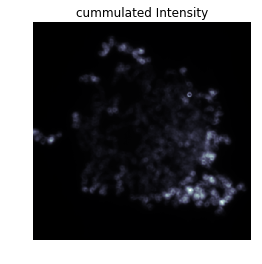

In [21]:
plt.figure()
plt.imshow(cummulated_image,cmap = 'bone')
plt.title('cummulated Intensity')
plt.axis('off')
plt.savefig('cummulated_Intesity_1JP')
plt.show()

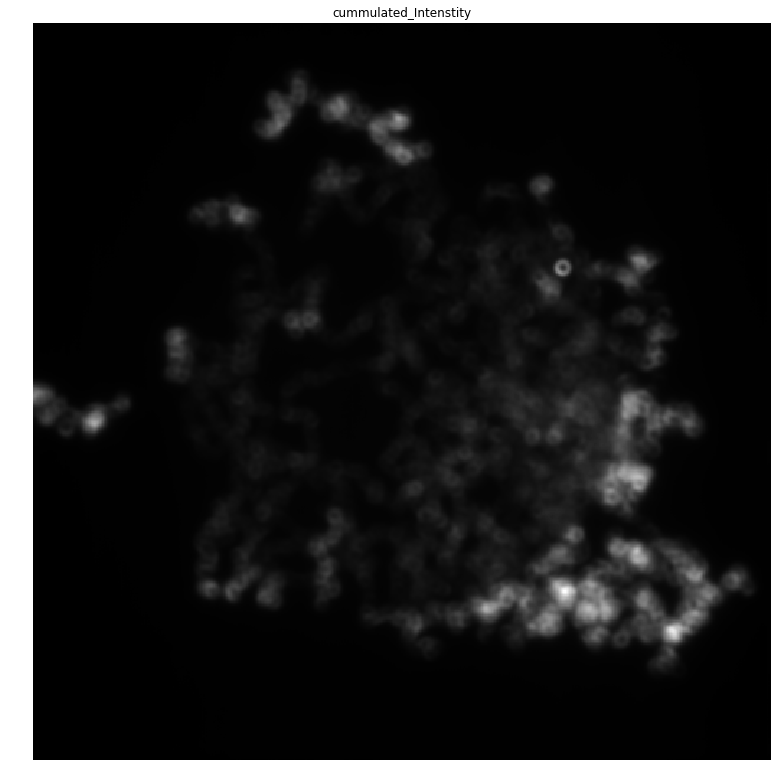

In [22]:
def display_image_in_actual_size(image):
    dpi = 50
    height, width= image.shape
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)
    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])
    # Hide spines, ticks, etc.
    ax.axis('off')
    # Display the image.
    ax.imshow(image, cmap='gray',interpolation='none')
    plt.title('cummulated_Intenstity')
    plt.savefig('cummulated_Intensity_JP_BOX')
    plt.show()
display_image_in_actual_size(cummulated_image)

In [7]:
file

NameError: name 'file' is not defined

In [23]:
## calculate all the angles and the interparticle distance
def Calc_distance_and_phi_rel():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    master_index_list = []
    phi_rel_o_list = [] # angle between orientations, but for the config (phi_o1 = phi_o2)
    phi_rel_o_real_list = [] #angle between orientations real (phi_o1 = -phi_o2)
    distance_list = []
    phi_p_list = [] # postitinal angle to partiner
    phi_po_list = [] # angle between positonal and orientaional angles
    for i in range(0,len(Tracked_particles['master_index']),2):
        y1 = Tracked_particles['y'].loc[i]
        x1 = Tracked_particles['x'].loc[i]
        y2 = Tracked_particles['y'].loc[i+1]
        x2 = Tracked_particles['x'].loc[i+1]
        distance_ij = np.sqrt((x1-x2)**2+(y1-y2)**2)
        distance_list.append(distance_ij)
        distance_list.append(distance_ij)
        phi1 = Tracked_particles['phi'].loc[i]
        phi2 = Tracked_particles['phi'].loc[i+1]
        phi_p1 = np.arctan2(x1-x2,y1-y2) - np.pi
        phi_p2 = phi_p1 + np.pi
        phi_rel = phi1 - phi2
        phi_po1 = phi_p1 - phi1
        phi_po2 = phi_p2 - phi2
        phi_rel_o_list.append(phi_rel)
        phi_rel_o_list.append(phi_rel)
        phi_rel_o_real_list.append(phi_rel)
        phi_rel_o_real_list.append(-phi_rel)
        phi_p_list.append(phi_p1)
        phi_p_list.append(phi_p2)
        phi_po_list.append(phi_po1)
        phi_po_list.append(phi_po2)
        master_index_list.append(Tracked_particles['master_index'].loc[i])
        master_index_list.append(Tracked_particles['master_index'].loc[i+1])
    phi_p_list = np.array(phi_p_list)
    phi_po_list = np.array(phi_po_list)
    phi_rel_o_list = np.array(phi_rel_o_list)
    phi_p_list[phi_p_list < -np.pi] += 2*np.pi ### phi should be in interval -pi,pi
    phi_po_list[phi_po_list < -np.pi] += 2*np.pi
    phi_rel_o_list[phi_rel_o_list < -np.pi] += 2*np.pi
    phi_p_list[phi_p_list > np.pi] -= 2*np.pi
    phi_po_list[phi_po_list > np.pi] -= 2*np.pi
    phi_rel_o_list[phi_rel_o_list > np.pi] -= 2*np.pi
    print(len(phi_p_list),len(phi_rel_o_list),len(distance_list),len( phi_po_list),len(master_index_list))
    tmp1 = pd.DataFrame({ 'master_index' : master_index_list,
                        'phi_o' : phi_rel_o_list,
                        'phi_o_real' : phi_rel_o_real_list,
                        'dist' : distance_list,
                        'phi_p_o' : phi_po_list,
                        'phi_p' : phi_p_list
                        })
    tmp2 = pd.merge(Tracked_particles,tmp1,on=['master_index'],how='outer')  ## merging the new data
    return tmp2
Tracked_particles = Calc_distance_and_phi_rel()

1826 1826 1826 1826 1826


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:54: FutureWarning: 'master_index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [66]:
## histogram of all orientations

def Plot_phi_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(dpi=200)
    plt.title('phi distribution')
    plt.xlabel('phi')
    plt.hist(list(Tracked_particles['phi']),bins = 50)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/phi_dist')
    plt.show()
    return
#Plot_phi_dist()

def Plot_state_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    state_list = []
    for i in range(len(usefull_particle_images)):
        state = len(usefull_particle_images[i][0])
        state_list.append(state)
    plt.figure(dpi=200)
    plt.title('state_distribution')
    plt.xlabel('state, small one is single, large one is close pair')
    plt.hist(state_list,bins = 2)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/state_dist')
    plt.show()
    return
#Plot_state_dist()

def Plot_interparticle_distance_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    distance_list = []
    Tracked_particles.groupby('master_index')
    for i in range(0,len(Tracked_particles['x']),2):
        y1 = Tracked_particles['y'].loc[i]
        x1 = Tracked_particles['x'].loc[i]
        y2 = Tracked_particles['y'].loc[i+1]
        x2 = Tracked_particles['x'].loc[i+1]
        distance_ij = np.sqrt((x1-x2)**2+(y1-y2)**2)
        distance_list.append(distance_ij)
    plt.figure(dpi=200)
    plt.title('interparticle distance distribution')
    plt.xlabel('distance in pxl')
    plt.hist(distance_list,bins = 40)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/distance_dist')
    plt.show()
    return
#Plot_interparticle_distance_dist()

def Plot_interparticle_distance_dist_weighted():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    distance_list = []
    weight_list = []
    Tracked_particles.groupby('master_index')
    for i in range(0,len(Tracked_particles['x']),2):
        y1 = Tracked_particles['y'].loc[i]
        x1 = Tracked_particles['x'].loc[i]
        y2 = Tracked_particles['y'].loc[i+1]
        x2 = Tracked_particles['x'].loc[i+1]
        distance_ij = np.sqrt((x1-x2)**2+(y1-y2)**2)
        distance_list.append(distance_ij)
        weight_list.append(event_radius/distance_ij)
    plt.figure(dpi=200)
    plt.title('weighted interparticle distance distribution')
    plt.xlabel('distance in pxl')
    plt.hist(distance_list,bins = 40,normed=True,weights=weight_list)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/distance_dist_weighted')
    plt.show()
    return
#Plot_interparticle_distance_dist_weighted()



def Plot_phi_rel_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    phi_rel_list = []
    Tracked_particles.groupby('master_index')
    for i in range(0,len(usefull_particle_images),2):
        phi1 = Tracked_particles['phi'].loc[i]
        phi2 = Tracked_particles['phi'].loc[i+1]
        phi_rel = phi1 - phi2
        if i ==0:
            print(phi_rel)
        if phi_rel > np.pi:
            phi_rel -= 2*np.pi
        if phi_rel < -np.pi:
            phi_rel += 2*np.pi
        phi_rel_list.append(phi_rel)
    plt.figure(dpi=200)
    plt.title('phi_ij distribution')
    plt.xlabel('phi_ij')
    plt.hist(phi_rel_list,bins = 50)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/phi_ij_dist')
    plt.show()
    return
#Plot_phi_rel_dist()

def Plot_phi_rel_vs_distance():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    Tracked_particles.groupby('master_index')
    phi_rel_list = []
    for i in range(0,len(usefull_particle_images),2):
        phi1 = Tracked_particles['phi'].loc[i]
        phi2 = Tracked_particles['phi'].loc[i+1]
        phi_rel = phi1 - phi2
        if i ==0:
            print(phi_rel)
        if phi_rel > np.pi:
            phi_rel -= 2*np.pi
        if phi_rel < -np.pi:
            phi_rel += 2*np.pi
        phi_rel_list.append(phi_rel)
    distance_list = []
    master_index_list = []
    for i in range(0,len(Tracked_particles['x']),2):
        y1 = Tracked_particles['y'].loc[i]
        x1 = Tracked_particles['x'].loc[i]
        y2 = Tracked_particles['y'].loc[i+1]
        x2 = Tracked_particles['x'].loc[i+1]
        distance_ij = np.sqrt((x1-x2)**2+(y1-y2)**2)
        distance_list.append(distance_ij)
    plt.figure(dpi=200)
    plt.hist2d(phi_rel_list,distance_list,cmap = 'gray')
    plt.title('phi_ij vs distance_ij')
    plt.xlabel('phi_ij')
    plt.ylabel('distance_ij in pxl')
    plt.colorbar()
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/phi_ij_distance_2D_dist')
    plt.show()
    return
#Plot_phi_o_vs_distance()


def Plot_phi_po():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(dpi=200)
    plt.hist(list(Tracked_particles['phi_p_o']),bins = 30)
    plt.title('orentation - position')
    plt.xlabel('in rad')
    return
#Plot_phi_po()


def Plot_phi_o():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(dpi=200)
    plt.hist(list(Tracked_particles['phi_o']),bins = 30)
    plt.title('orentation')
    plt.xlabel('in rad')
    return
#Plot_phi_o()



def Plot_phi_p():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(dpi=200)
    plt.hist(list(Tracked_particles['phi_p']),bins = 30)
    plt.title('position angle')
    plt.xlabel('in rad')
    return
#Plot_phi_p()

def hist_phi_po_vs_distance():
    return







def Plot_position_desity():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(figsize = (10,7),dpi = 200)
    plt.hist2d(Tracked_particles['x'],Tracked_particles['y'],cmap = 'gray',bins = 100)
    plt.title('positional density for events')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/XYdensity')
    plt.show()
    return
#Plot_position_desity()

interactive(children=(IntSlider(value=222, description='i', max=444), Output()), _dom_classes=('widget-interact',))

<function __main__.ShowSingleDoubls>

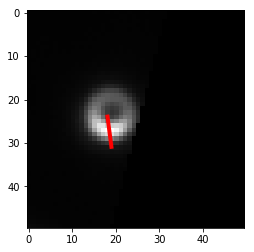

In [62]:
## look though some trackings

def ShowSingleDoubls(i):
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.imshow(usefull_particle_images[i],cmap = 'gray')
    x_rel = Tracked_particles['x_rel'].loc[i]
    y_rel = Tracked_particles['y_rel'].loc[i]
    phi = Tracked_particles['phi'].loc[i]
    plt.plot([x_rel,x_rel+7*np.sin(phi)],[y_rel,y_rel+7*np.cos(phi)],color ='r',lw = 4)
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/expample_tracked_particle')
    plt.show()
    frame = Tracked_particles['frame_rel'][i]
    y = Tracked_particles['y'][i]
    x = Tracked_particles['x'][i] #-"-   # something is messupo here but it works
    #plt.figure(figsize=(10,10))
    file = Tracked_particles['file'][i]
    tdms_file = TdmsFile(file)
    p=tdms_file.object().properties   
    dimx=int(p['dimx'])  
    dimy=int(p['dimy'])
    frames=int(p['dimz'])
    images=tdms_file.channel_data('Image','Image')
    series = images.reshape(frames,dimx,dimy)
    #print(udlr_list)
    #print(udlr_list[2:])
    #plt.imshow(series[frame])
    #plt.scatter(y,x,s=10,c='red',lw=0)
    #plt.scatter(udlr_list[2:],udlr_list[:2],color = 'orange')
    #plt.show()
    plt.figure(dpi=300)
    ax = plt.gca()
    ax.cla() # clear things for fresh plot
    circle1 = plt.Circle((512//2, 512//2), 120, color='r', fill=False)
    ax.imshow(series[frame],cmap = 'gray')
    ax.scatter(x,y,s=10,marker = '+',c='red',lw = 0.5)
    ax.add_artist(circle1)
    phi_p = Tracked_particles['phi_p'].loc[i]
    ax.plot([x,x+40*np.sin(phi_p)],[y,y+40*np.cos(phi_p)],color ='r',lw = 0.5)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/expample_marked_particle')
    plt.show()
    print('x,y = ',x,y, '  ; frame', frame, '  ; file ',file)
    return
interact(ShowSingleDoubls,i = (0,444))
#interact(ShowSingleDoubls,i = (0,1))

In [26]:
len(usefull_particle_images)

1826

In [27]:
t = tp.link_df(Tracked_particles,15,memory = 4);

Frame 1509: 2 trajectories present.


In [33]:
t.head()

Unnamed: 0           x           y       phi  \
master_index                                                 
0                      0  377.195122  211.536585  2.326241   
1                      1  367.012658  233.044304 -2.294178   
2                      2  375.314286  212.182857  2.405017   
3                      3  366.949367  234.500000 -2.723933   
4                      4  373.825137  213.136612  2.345197   

                                                           file  file_counter  \
master_index                                                                    
0             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
1             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
2             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
3             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
4             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   

              frame_rel      x_rel     y_rel                  udlr  partner  \
master_index                                                                  
0                     7   9.195122  9.536585  [220, 202, 368, 386]        1   
1                     7  10.012658  9.044304  [242, 224, 357, 375]        0   
2                     8   9.314286  9.182857  [221, 203, 366, 384]        3   
3                     8   9.949367  9.500000  [243, 225, 357, 375]        2   
4                     9   9.825137  9.136612  [222, 204, 364, 382]        5   

              frame  master_index     phi_o  phi_o_real       dist   phi_p_o  \
master_index                                                                   
0                 7             0 -1.662767    4.620419  23.796313 -2.768410   
1                 7             1 -1.662767   -4.620419  23.796313 -1.289584   
2                 8             2 -1.154235    5.128950  23.833311 -2.763631   
3                 8             3 -1.154235   -5.128950  23.833311 -0.776273   
4                 9             4 -1.378931    4.904254  24.331091 -2.602862   

                 phi_p  particle  
master_index                      
0            -0.442169         0  
1             2.699424         1  
2            -0.358613         0  
3             2.782980         1  
4            -0.257665         0

In [ ]:
del t1

In [34]:
t1 = tp.filter_stubs(t, 3)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 89
After: 77


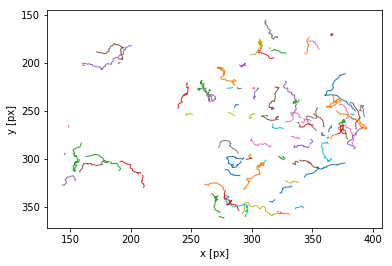

In [35]:
tp.plot_traj(t1)

In [36]:
#####   OLD!!!!!!!!  THIS WILL CHRASH THE PC IF THE DATA IS TO BIG -> use the split version of this!!!
n_dist_bins = 20
n_phi_bins = 20
dist_binsize = event_radius/n_dist_bins
phi_binsize = 2*np.pi/n_phi_bins
dist_bins = np.array(range(0,n_dist_bins,1))
phi_p_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
phi_po_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
phi_o_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
dist_bins_abs = np.array(range(0,n_dist_bins,1))*dist_binsize
phi_p_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
phi_po_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
phi_o_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
bin_dict = {'phi_p_bin' : phi_p_bins_abs,'dist_bin' : dist_bins_abs, 'phi_po_bin' : phi_po_bins_abs,'phi_o_bin' : phi_o_bins_abs}

import os, sys
def Compute_displacements():
    ## copy from trackpy
    #print('t1',t1.shape)
    ### i copyed the method of claculating the differences from trackpy and had to improvies on getting the data merged with mine...
    ## if this thing demands to much RAM, split it into particle wise, of do it dvalue after dvalue
    
    lagtime = 1   # over how many frames the difference is taken
    mpp = 1  # for units i guess
    t1.set_index(['frame'],drop = False,inplace = True)
    xpos = t1.set_index(['frame', 'particle'])['x'].unstack() # particles as columns
    #xpos = xpos.reindex(np.arange(xpos.index[0], 1 + xpos.index[-1]))  ## and fill up the missing frames with nans
    xdisp = mpp*xpos.sub(xpos.shift(lagtime)) #  do the substraction
    ypos = t1.set_index(['frame', 'particle'])['y'].unstack() # particles as columns
    #ypos = ypos.reindex(np.arange(ypos.index[0], 1 + ypos.index[-1]))
    ydisp = mpp*ypos.sub(ypos.shift(lagtime))
    phipos = t1.set_index(['frame', 'particle'])['phi'].unstack() # particles as columns
    #phipos = phipos.reindex(np.arange(phipos.index[0], 1 + phipos.index[-1]))
    phidisp = mpp*phipos.sub(phipos.shift(lagtime))
    phi_p_pos = t1.set_index(['frame', 'particle'])['phi_p'].unstack() # particles as columns 
    #phi_p_pos = phi_p_pos.reindex(np.arange(phi_p_pos.index[0], 1 + phi_p_pos.index[-1]))
    phi_p_disp = mpp*phi_p_pos.sub(phi_p_pos.shift(lagtime))
    phi_po_pos = t1.set_index(['frame', 'particle'])['phi_p_o'].unstack() # particles as columns 
    #phi_po_pos = phi_po_pos.reindex(np.arange(phi_po_pos.index[0], 1 + phi_po_pos.index[-1]))
    phi_po_disp = mpp*phi_po_pos.sub(phi_po_pos.shift(lagtime))
    dist_pos = t1.set_index(['frame', 'particle'])['distance_ij'].unstack() # particles as columns 
    #dist_pos = dist_pos.reindex(np.arange(dist_pos.index[0], 1 + dist_pos.index[-1]))
    dist_disp = mpp*dist_pos.sub(dist_pos.shift(lagtime))
    phi_o_pos = t1.set_index(['frame', 'particle'])['phi_o'].unstack() # particles as columns 
    #phi_o_pos = phi_o_pos.reindex(np.arange(phi_o_pos.index[0], 1 + phi_o_pos.index[-1]))
    phi_o_disp = mpp*phi_o_pos.sub(phi_o_pos.shift(lagtime))
    phi_o_real_pos = t1.set_index(['frame', 'particle'])['phi_o'].unstack() # particles as columns 
    #phi_o_pos = phi_o_pos.reindex(np.arange(phi_o_pos.index[0], 1 + phi_o_pos.index[-1]))
    phi_o_real_disp = mpp*phi_o_pos.sub(phi_o_pos.shift(lagtime))
    
    ## now for real!!!
    index_p = xdisp.T.index
    index_f = xdisp.index
    
    usefull_indices = np.argwhere(np.invert(np.isnan(xdisp.values)))
    dx_list = np.empty(len(usefull_indices))    ### prepear the lists
    dx_list[:] = np.nan
    dy_list = np.empty(len(usefull_indices))
    dy_list[:] = np.nan
    dphi_list = np.empty(len(usefull_indices))
    dphi_list[:] = np.nan
    dphi_p_list = np.empty(len(usefull_indices))
    dphi_p_list[:] = np.nan
    dphi_po_list = np.empty(len(usefull_indices))
    dphi_po_list[:] = np.nan
    ddist_list = np.empty(len(usefull_indices))
    ddist_list[:] = np.nan
    dphi_o_list = np.empty(len(usefull_indices))
    dphi_o_list[:] = np.nan
    dphi_o_real_list = np.empty(len(usefull_indices))
    dphi_o_real_list[:] = np.nan
    frame_list = np.empty(len(usefull_indices))
    particle_list = np.empty(len(usefull_indices))
    print(len(usefull_indices))

    bin_trigger = False
    #bin_trigger = True   # no need for this anymore, i desicded to make a dynamical binning i.e. binning is made in the plotfuncitns
    if bin_trigger:                                             ## prepareation for event binning
        dist_bin_list = np.empty(len(usefull_indices))
        phi_p_bin_list = np.empty(len(usefull_indices))
        phi_po_bin_list = np.empty(len(usefull_indices))
        phi_o_bin_list = np.empty(len(usefull_indices))
        
        t1.set_index(['frame','particle'],drop = False,inplace = True)
    for n in range(len(usefull_indices)):                        ### set all the displacements
        p = list(xdisp.T.index)[usefull_indices[n][1]]
        f = list(xdisp.index)[usefull_indices[n][0]]
        dx_list[n] = xdisp.loc[(f,p)]
        dy_list[n] = ydisp.loc[(f,p)]
        dphi_list[n] = phidisp.loc[(f,p)]
        dphi_p_list[n] = phi_p_disp.loc[(f,p)]
        dphi_po_list[n] = phi_po_disp.loc[(f,p)]
        ddist_list[n] = dist_disp.loc[(f,p)]
        dphi_o_list[n] = phi_o_disp.loc[(f,p)]
        dphi_o_real_list[n] = phi_o_real_disp.loc[(f,p)]
        frame_list[n] = f
        particle_list[n] = p
        if bin_trigger:                                           ### here comes all the event binning
            #print('shcakaka')
            dist = float(t1.loc[(f,p),['distance_ij']])
            phi_p = float(t1.loc[(f,p),['phi_p']])
            phi_po = float(t1.loc[(f,p),['phi_p_o']])
            phi_o = float(t1.loc[(f,p),['phi_o']])
            done1 = False
            done2 = False
            done3 = False
            done4 = False
            k = 0
            while done1 ==False:
                bound_l = dist_bins_abs[k]
                if (bound_l < dist) and (dist <= bound_l+ dist_binsize):
                    dist_bin_list[n] = bound_l
                    done1 = True
                elif k == len(dist_bins_abs)-1:   #pls dont ask me why the -1 is necessary, but it is
                    #print('dis is to high  ',dist)
                    dist_bin_list[n] = bound_l  ## throw eh in the last dist bin anyways.... how cares... cant be too bad...
                    done1 = True
                k += 1
            k = 0
            while done2 ==False:
                bound_l = phi_p_bins_abs[k]
                if (bound_l < phi_p) and (phi_p <= bound_l+ phi_binsize):
                    phi_p_bin_list[n] = bound_l
                    done2 = True
                k += 1
            k = 0
            while done3 ==False:
                bound_l = phi_po_bins_abs[k]
                if (bound_l < phi_po) and (phi_po <= bound_l+ phi_binsize):
                    phi_po_bin_list[n] = bound_l
                    done3 = True
                k +=1
            k = 0
            while done4 ==False:
                bound_l = phi_o_bins_abs[k]
                if (bound_l < phi_o) and (phi_o <= bound_l+ phi_binsize):
                    phi_o_bin_list[n] = bound_l
                    done4 = True
                k +=1
            if (not done1) or (not done2) or (not done3) or (not done4):  #### check if there is an event taht wasnt binned... i desided to throw all the outer dist events into the last bin...
                print('not binned event!! p,f is ',p,f,' which:  ',done1,done2,done3,done4)
        sys.stdout.write(('='*(int(n/len(usefull_indices)*100) + 1))+(''*(100-int(n/len(usefull_indices)*100) + 1))+("\r [ %d"%int(n/len(usefull_indices)*100 + 1)+"% ] "))
        sys.stdout.flush()
    dphi_list[dphi_list < -np.pi] += 2*np.pi
    dphi_list[dphi_list > np.pi] -= 2*np.pi
    dphi_p_list[dphi_p_list < -np.pi] += 2*np.pi
    dphi_p_list[dphi_p_list > np.pi] -= 2*np.pi
    dphi_po_list[dphi_po_list < -np.pi] += 2*np.pi
    dphi_po_list[dphi_po_list > np.pi] -= 2*np.pi
    dphi_o_list[dphi_o_list < -np.pi] += 2*np.pi
    dphi_o_list[dphi_o_list > np.pi] -= 2*np.pi
    dphi_o_real_list[dphi_o_list < -np.pi] += 2*np.pi
    dphi_o_real_list[dphi_o_list > np.pi] -= 2*np.pi
    
    
    ### now make a data frame to merge with the gib data frame
    tmp = pd.DataFrame({ 'dx' : dx_list,
                        'dy' : dy_list,
                        'dphi' : dphi_list,
                        'dphi_p' : dphi_p_list,
                        'dphi_p_o' : dphi_po_list,
                        'ddist' : ddist_list,
                        'dphi_o' :dphi_o_list,
                        'dphi_o_real':dphi_o_real_list,
                       'frame' : frame_list,
                       'particle' : particle_list})
    t1.set_index(['frame','particle'],drop = False,inplace = True)
    t2 = pd.merge(t1,tmp,on=['particle','frame'],how='outer')         ### here the data is merged
    if bin_trigger:
        tmp1 = pd.DataFrame({ 'dist_bin' : dist_bin_list,
                    'phi_p_bin' : phi_p_bin_list,
                    'phi_po_bin' : phi_po_bin_list,
                    'phi_o_bin' : phi_o_bin_list,
                    'frame' : frame_list,
                    'particle' : particle_list})
        t3 = pd.merge(t2,tmp1,on=['particle','frame'],how='outer')
    
    ###--------ploting all events-------------------------------------------
    xvalues = xdisp.values.flatten()
    xvalues = xvalues[np.isfinite(xvalues)]
    plt.figure()
    plt.hist(xvalues,bins = 40)
    plt.xlabel('dx in plx')
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/dx_dist')
    plt.show()
    
    yvalues = ydisp.values.flatten()
    yvalues = yvalues[np.isfinite(yvalues)]
    plt.figure()
    plt.hist(yvalues,bins = 40)
    plt.xlabel('dy in plx')
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/dy_dist')
    plt.show()
    
    '''
    # Let np.histogram choose the best bins for all the data together.
    phivalues = phidisp.values.flatten()
    phivalues = phivalues[np.isfinite(phivalues)]
    phivalues[phivalues > np.pi] -= 2*np.pi
    phivalues[phivalues < -np.pi] += 2*np.pi
    plt.figure()
    plt.hist(phivalues,bins = 150)
    plt.xlabel('dphi in rad')
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/dphi_dist')
    plt.show()
    '''
    if bin_trigger:
        return t3
    return t2
#this guy is old, it need to much RAM, so use the spilt version, where all differences are caled. seperatly     t1 = Compute_displacements()



In [37]:
pxl_mu = 0.128
phi_unit = 1
unit_dict = {'x': pxl_mu,'y': pxl_mu, 'phi': phi_unit, 'phi_o' : phi_unit,'phi_o_real' : phi_unit, 'phi_p' : phi_unit, 'phi_p_o' : phi_unit, 'dist': pxl_mu, 'dphi': phi_unit, 'dy': pxl_mu, 'dx': pxl_mu, 'ddist': pxl_mu, 'dr_parallel': pxl_mu, 'dr_p': pxl_mu, 'dphi_o': phi_unit, 'dphi_o_real': phi_unit,'dphi_p_o': phi_unit, 'dphi_p': phi_unit }


def Compute_displacement_quantity(quantity = 'x'):
    lagtime = 1   # over how many frames the difference is taken
    mpp = 1  # for units i guess
    t1.set_index(['frame'],drop = False,inplace = True)
    pos = t1.set_index(['frame', 'particle'])[quantity].unstack() # particles as columns
    #xpos = xpos.reindex(np.arange(xpos.index[0], 1 + xpos.index[-1]))  ## and fill up the missing frames with nans
    disp = mpp*pos.sub(pos.shift(lagtime)) #  do the substraction
    index_p = disp.T.index
    index_f = disp.index
    
    usefull_indices = np.argwhere(np.invert(np.isnan(disp.values)))
    d_list = np.empty(len(usefull_indices))    ### prepear the lists
    d_list[:] = np.nan
    frame_list = np.empty(len(usefull_indices))
    particle_list = np.empty(len(usefull_indices))
    for n in range(len(usefull_indices)):                        ### set all the displacements
        p = list(disp.T.index)[usefull_indices[n][1]]
        f = list(disp.index)[usefull_indices[n][0]]
        d_list[n] = disp.loc[(f,p)]
        frame_list[n] = f
        particle_list[n] = p
    
    
    
    if unit_dict[quantity] == phi_unit:
        d_list[d_list < -np.pi] += 2*np.pi
        d_list[d_list > np.pi] -= 2*np.pi
    
    new_quantity = 'd'+quantity
    
    ### now make a data frame to merge with the gib data frame
    tmp = pd.DataFrame({ new_quantity : d_list,
                       'frame' : frame_list,
                       'particle' : particle_list})
    t1.set_index(['frame','particle'],drop = False,inplace = True)
    t2 = pd.merge(t1,tmp,on=['particle','frame'],how='outer')         ### here the data is merged
    print('done with calulation of ',new_quantity)
    return t2

t1 = Compute_displacement_quantity(quantity = 'x') 
t1 = Compute_displacement_quantity(quantity = 'y')
t1 = Compute_displacement_quantity(quantity = 'dist')
t1 = Compute_displacement_quantity(quantity = 'phi')
t1 = Compute_displacement_quantity(quantity = 'phi_o')
t1 = Compute_displacement_quantity(quantity = 'phi_p')
t1 = Compute_displacement_quantity(quantity = 'phi_p_o')
t1 = Compute_displacement_quantity(quantity = 'phi_o_real')


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  dx


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:46: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  dy


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  ddist


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  dphi


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:49: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  dphi_o


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  dphi_p


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


done with calulation of  dphi_p_o
done with calulation of  dphi_o_real


/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: 'particle' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:52: FutureWarning: 'frame' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


In [38]:
t1.head()

Unnamed: 0           x           y       phi  \
0           0  377.195122  211.536585  2.326241   
1           1  367.012658  233.044304 -2.294178   
2           2  375.314286  212.182857  2.405017   
3           3  366.949367  234.500000 -2.723933   
4           4  373.825137  213.136612  2.345197   

                                                file  file_counter  frame_rel  \
0  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0          7   
1  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0          7   
2  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0          8   
3  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0          8   
4  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0          9   

       x_rel     y_rel                  udlr     ...          phi_p  particle  \
0   9.195122  9.536585  [220, 202, 368, 386]     ...      -0.442169         0   
1  10.012658  9.044304  [242, 224, 357, 375]     ...       2.699424         1   
2   9.314286  9.182857  [221, 203, 366, 384]     ...      -0.358613         0   
3   9.949367  9.500000  [243, 225, 357, 375]     ...       2.782980         1   
4   9.825137  9.136612  [222, 204, 364, 382]     ...      -0.257665         0   

         dx        dy     ddist      dphi    dphi_o    dphi_p  dphi_p_o  \
0       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2 -1.880836  0.646272  0.036998  0.078777  0.508532  0.083556  0.004779   
3 -0.063291  1.455696  0.036998 -0.429755  0.508532  0.083556  0.513311   
4 -1.489149  0.953755  0.497779 -0.059821 -0.224696  0.100948  0.160769   

   dphi_o_real  
0          NaN  
1          NaN  
2     0.508532  
3    -0.508532  
4    -0.224696  

[5 rows x 27 columns]

In [39]:
t1.to_csv('t1.csv')

In [40]:
n_dist_bins = 20
n_phi_bins = 20
dist_binsize = event_radius/n_dist_bins
phi_binsize = 2*np.pi/n_phi_bins
dist_bins = np.array(range(0,n_dist_bins,1))
phi_p_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
phi_po_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
dist_bins_abs = np.array(range(0,n_dist_bins,1))*dist_binsize
phi_p_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
phi_po_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
#print(dist_bins_abs)

def Plot_phi_displacement_hist(dist_bin,phi_po_bin):
    t1.set_index(['particle'],drop = False,inplace = True)
    t1.set_index(['phi_p_bin','dist_bin'],drop = False,inplace = True)
    i = phi_po_bin
    j = dist_bin
    print('d_ij ', dist_bins_abs[j],' and ',dist_bins_abs[j]+dist_binsize, 'pxl')
    print('phi_po between ', phi_po_bins_abs[i],' and ',phi_po_bins_abs[i]+phi_binsize,' rad')
    dphi_list = list(t1.loc[(phi_po_bins_abs[i],dist_bins_abs[j]),'dphi'])
    #print(dphi_list)
    print('N : ',len(dphi_list))
    n_bins = 180
    plt.figure()
    plt.hist(dphi_list,bins = n_bins)
    plt.xlabel('delta phi')
    plt.show()
    return
#Plot_phi_displacement_hist(5,5)
#interact(Plot_phi_displacement_hist,dist_bin = (0,n_dist_bins),phi_po_bin = (0,n_phi_bins))




def Plot_binned_displacement_hist(quantity = 'dphi',first = 'dist_bin',i = 0,second = 'phi_po_bin',j = 0,n_bins = 50):
    first_bin = np.array(bin_dict[first])[i]
    second_bin = np.array(bin_dict[second])[j]
    t1.set_index([first,second],drop = False,inplace = True)
    print('first bin is at: ',first_bin,'+binsize ; second is at: ', second_bin,' +binsize')
    try:
        if quantity == 'dr':
            dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
            dx = dx[np.isfinite(dx)]
            dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
            dy = dy[np.isfinite(dy)]
            data= np.sqrt(dx**2+dy**2)
        elif quantity =='dr_parallel':
            dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
            dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
            phi = np.array(t1.loc[(first_bin,second_bin),'phi'])
            data = np.zeros(len(dx))
            for k in range(len(dx)):
                data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
        elif quantity =='dr_antiparallel':
            dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
            dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
            phi = np.array(t1.loc[(first_bin,second_bin),'phi'])
            data = np.zeros(len(dx))
            for k in range(len(dx)):
                data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
        elif quantity =='dr_p':
            dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
            dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
            phi = np.array(t1.loc[(first_bin,second_bin),'phi_p'])
            data = np.zeros(len(dx))
            for k in range(len(dx)):
                data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
        else:
            data = np.array(t1.loc[(first_bin,second_bin),quantity])
        N = len(data)
        print('N = ',N)
        plt.figure(dpi=100)
        if N>15:
            ## fiting 
            hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
            bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
            
            # Define model function to be used to fit to the data above:
            def gauss(x, *p):
                A, mu, sigma = p
                return A*np.exp(-(x-mu)**2/(2.*sigma**2))
            # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
            p0 = [1., 0., 1.]
            coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
            hist_fit = gauss(bin_centres, *coeff)
            plt.plot(bin_centres, hist_fit, label='routine fit')
            print('Fitted mean = ', coeff[1])
            print('Fitted standard deviation = ', np.abs(coeff[2]))
        plt.hist(data,bins = n_bins,normed=True)
        plt.xlabel(quantity)
        plt.show()
 
    except KeyError:
        print('no events here')
    return 
#interact(Plot_binned_displacement_hist,quantity = 'dphi',first = 'dist_bin',i = (0,20),second = 'phi_po_bin',j = (0,20),n_bins = 50)

def Fit_phi_displacement_hist(dist_bin,phi_po_bin):
    t1.set_index(['phi_p_bin','dist_bin'],drop = False,inplace = True)
    i = phi_po_bin
    j = dist_bin
    print('d_ij ', dist_bins_abs[j],' and ',dist_bins_abs[j]+dist_binsize, 'pxl')
    print('phi_po between ', phi_po_bins_abs[i],' and ',phi_po_bins_abs[i]+phi_binsize,' rad')
    dphi_list = np.array(t1.loc[(phi_po_bins_abs[i],dist_bins_abs[j]),'dphi'])
    #print(dphi_list)
    print('N : ',len(dphi_list))
    n_bins = 100
    ## fiting 
    #_________________________________________________________________________
    # Define some test data which is close to Gaussian
    data = dphi_list
    hist, bin_edges = numpy.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))
    
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]
    
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)
    #__________simple moment calculation and fit____________there is something wrong here!!!!!!!!!__________________
    X = np.arange(data.size)
    x = np.sum(X*data)/np.sum(data)
    width = np.sqrt(np.abs(np.sum((X-x)**2*data)/np.sum(data)))
    
    mean= np.mean(dphi_list)
    std = np.std(dphi_list)
    
    max = 1/(std*np.sqrt(2*np.pi))
    
    hist_fit2 = gauss(bin_centres, max,mean,std)
    print('asdfasdfasfdasdfasd',np.sqrt(scipy.stats.moment(dphi_list,moment=2)))
    
    #________________________________________________________________________________
    
    plt.figure(dpi = 100)
    plt.hist(dphi_list,bins = n_bins,normed=True)
    plt.plot(bin_centres, hist_fit, label='routine fit')
    plt.plot(bin_centres, hist_fit2, label='simple fit ')
    plt.xlabel('delta phi')
    plt.legend()
    plt.show()
    print(' mean = ',mean)
    print(' standard deviation = ', std)
    print('Fitted mean = ', coeff[1])
    print('Fitted standard deviation = ', np.abs(coeff[2]))
    return
#interact(Fit_phi_displacement_hist,dist_bin = (0,n_dist_bins),phi_po_bin = (0,n_phi_bins))


def Plot_displacement_hist(quantity,n_bins = 100,fit = False,mode = 'normal'):
    t1.set_index(['master_index'],drop = False,inplace = True)
    if quantity == 'dr':
        print('yes')
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        dy = dy[np.isfinite(dy)]
        values = np.sqrt(dx**2+dy**2)
    elif quantity == 'dr_parallel':
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        usefull_data = np.isfinite(dy)
        dy = dy[np.isfinite(dy)]
        phi = np.array(t1['phi'])
        phi = phi[usefull_data]
        values = np.zeros(len(phi))
        for k in range(len(dx)):
            values[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    elif quantity == 'dr_antiparallel':
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        usefull_data = np.isfinite(dy)
        dy = dy[np.isfinite(dy)]
        phi = np.array(t1['phi'])
        phi = phi[usefull_data]
        values = np.zeros(len(phi))
        for k in range(len(dx)):
            values[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
    elif quantity == 'dr_p':
        dx = np.array(t1['dx'])
        dx = dx[np.isfinite(dx)]
        dy = np.array(t1['dy'])
        usefull_data = np.isfinite(dy)
        dy = dy[np.isfinite(dy)]
        phi_p = np.array(t1['phi_p'])
        phi_p = phi[usefull_data]
        values = np.zeros(len(phi))
        for k in range(len(dx)):
            values[k] = -np.dot([dx[k],dy[k]],[np.sin(phi_p[k]+np.pi/2),np.cos(phi_p[k]+np.pi/2)])
    else:
        values = np.array(t1[quantity])
        values = values[np.isfinite(values)]
    if mode == 'abs':
        values = np.abs(values)
    elif mode == 'squared':
        values = values**2
    plt.figure()
    plt.hist(values,bins = n_bins,normed=True)
    if fit:# from https://stackoverflow.com/questions/11507028/fit-a-gaussian-function/11507723#11507723
        data = values
        hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., 0., 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
        # Get the fitted curve
        hist_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, hist_fit, label='routine fit')
        print('Fitted mean = ', coeff[1])
        print('Fitted standard deviation = ', np.abs(coeff[2]))
    plt.xlabel(quantity)
    plt.show()
    return coeff[1], np.abs(coeff[2])
#Plot_mean_displacement_hist_2D('dr',n_bins = 150,fit =True,mode = 'normal')

def Plot_disp_along_phi():
    ### pfojection of dr on orientaion
    n_bins = 150
    dx = np.array(t1['dx'])
    usefull_events = np.isfinite(dx)
    dx = dx[usefull_events]
    dy = np.array(t1['dy'])
    dy = dy[usefull_events]
    phi = np.array(t1['phi'])
    phi = phi[usefull_events]
    values = np.zeros(len(dx))
    for i in range(len(dx)):
        values[i] = -np.dot([dx[i],dy[i]],[np.sin(phi[i]),np.cos(phi[i])])
    plt.figure()
    fit = True
    if fit:# from https://stackoverflow.com/questions/11507028/fit-a-gaussian-function/11507723#11507723
        data = values
        hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., 0., 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
        # Get the fitted curve
        hist_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, hist_fit, label='routine fit')
        print('Fitted mean = ', coeff[1])
        print('Fitted standard deviation = ', np.abs(coeff[2]))
    plt.hist(values,bins = n_bins,normed=True)
    plt.xlabel('displacement along particle axis')
    plt.show()
    return
#Plot_disp_along_phi()

def Plot_disp_along_phi_p():
    ### pfojection of dr on orientaion
    n_bins = 150
    dx = np.array(t1['dx'])
    usefull_events = np.isfinite(dx)
    dx = dx[usefull_events]
    dy = np.array(t1['dy'])
    dy = dy[usefull_events]
    phi = np.array(t1['phi_p'])
    phi = phi[usefull_events]
    values = np.zeros(len(dx))
    for i in range(len(dx)):
        values[i] = -np.dot([dx[i],dy[i]],[np.sin(phi[i]),np.cos(phi[i])])
    plt.figure()
    fit = True
    if fit:# from https://stackoverflow.com/questions/11507028/fit-a-gaussian-function/11507723#11507723
        data = values
        hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
        bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
        # Define model function to be used to fit to the data above:
        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))
        # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
        p0 = [1., 0., 1.]
        coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
        # Get the fitted curve
        hist_fit = gauss(bin_centres, *coeff)
        plt.plot(bin_centres, hist_fit, label='routine fit')
        print('Fitted mean = ', coeff[1])
        print('Fitted standard deviation = ', np.abs(coeff[2]))
    plt.hist(values,bins = n_bins,normed=True)
    plt.xlabel('displacement to neighbourparticle')
    plt.show()
    return
#Plot_disp_along_phi()


def Plot_bin_hist_2D_phi_po_vs_dist():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    Tracked_particles.groupby('master_index')
    phi_po_list = []
    distance_list = []
    master_index_list = []
    for i in range(0,len(Tracked_particles['x'])):
        distance_ij = Tracked_particles['distance_ij'].loc[i]
        distance_list.append(distance_ij)
        phi_po = Tracked_particles['phi_p_o'].loc[i]
        phi_po_list.append(phi_po)
    plt.figure(dpi=200)
    phi_edges = list(phi_o_bins_abs)
    phi_edges.append(phi_o_bins_abs[-1]+phi_binsize)# the most right edges has to be added
    dist_edges = list(dist_bins_abs)
    dist_edges.append(dist_bins_abs[-1]+dist_binsize)
    plt.hist2d(phi_po_list,distance_list,cmap = 'gray',bins = [phi_edges,dist_edges])
    plt.title('phi_po vs distance_ij')
    plt.xlabel('phi_po')
    plt.ylabel('distance_ij in pxl')
    plt.colorbar()
    plt.savefig('phi_ij_distance_2D_dist')
    plt.show()
    return
#Plot_bin_hist_2D_phi_po_vs_dist()

def Plot_mean_bin_hist(quantity = 'dphi',first = 'dist_bin'):
    bin_dict = {'phi_p_bin' : phi_p_bins_abs,'dist_bin' : dist_bins_abs, 'phi_po_bin' : phi_po_bins_abs,'phi_o_bin' : phi_o_bins_abs}
    M_mean = np.zeros(len(bin_dict[first]))
    M_mean[:] = np.nan
    M_std = np.zeros(len(bin_dict[first]))
    M_std[:] = np.nan
    M_uncert = np.zeros(len(bin_dict[first]))
    M_uncert[:] = np.nan
    M_N = np.zeros(len(bin_dict[first]))
    j = 0
    for first_bin in bin_dict[first]:
        t1.set_index([first],drop = False,inplace = True)
        try:
            if quantity == 'dr':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dx = dx[np.isfinite(dx)]
                dy = np.array(t1.loc[(first_bin),'dy'])
                dy = dy[np.isfinite(dy)]
                data= np.sqrt(dx**2+dy**2)
            elif quantity =='dr_parallel':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dy = np.array(t1.loc[(first_bin),'dy'])
                phi = np.array(t1.loc[(first_bin),'phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
            elif quantity =='dr_antiparallel':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dy = np.array(t1.loc[(first_bin),'dy'])
                phi = np.array(t1.loc[(first_bin),'phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
            elif quantity =='dr_p':
                dx = np.array(t1.loc[(first_bin),'dx'])
                dy = np.array(t1.loc[(first_bin),'dy'])
                phi_p = np.array(t1.loc[(first_bin),'phi_p'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi_p[k]+np.pi/2),np.cos(phi_p[k]+np.pi/2)])
            else:
                data = np.array(t1.loc[(first_bin),quantity])
            N = len(data)
            M_N[j] = N
            if N>40:
                n_bins = 100
                ## fiting 
                hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
                # Define model function to be used to fit to the data above:
                def gauss(x, *p):
                    A, mu, sigma = p
                    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                p0 = [1., 0., 1.]
                coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                M_mean[j] = coeff[1]  # write the mean innto the matrix
                M_std[j] = np.abs(coeff[2])
                M_uncert[j] = np.abs(var_matrix[1,1])
            else:
                M_mean[j] = np.nan
                M_std[j] = np.nan
                M_uncert[j] = np.nan
        except KeyError:
            M_mean[j] = np.nan
            M_std[j] = np.nan
            M_uncert[j] = np.nan
            M_N[j] = 0
        j+=1
    plt.figure()
    plt.errorbar(bin_dict[first],M_mean,yerr=M_uncert , xerr=M_uncert , fmt='o')
    plt.title('mean '+quantity)
    plt.ylabel(quantity)
    plt.xlabel(first)
    plt.grid()
    plt.show()
    return
#Plot_mean_bin_hist(quantity = 'dphi',first = 'dist_bin')


def Plot_mean_2bins_hist(quantity = 'dphi',first = 'dist_bin',second = 'phi_po_bin'):
    bin_dict = {'phi_p_bin' : phi_p_bins_abs,'dist_bin' : dist_bins_abs, 'phi_po_bin' : phi_po_bins_abs,'phi_o_bin' : phi_o_bins_abs}
    M_mean = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_mean[:,:] = np.nan
    M_std = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_std[:,:] = np.nan
    M_uncert = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_uncert[:,:] = np.nan
    M_N = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    j = 0
    for first_bin in bin_dict[first]:
        i = 0
        for second_bin in bin_dict[second]:
            t1.set_index([first,second],drop = False,inplace = True)
            try:
                if quantity == 'dr':
                    dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
                    dx = dx[np.isfinite(dx)]
                    dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
                    dy = dy[np.isfinite(dy)]
                    data= np.sqrt(dx**2+dy**2)
                elif quantity =='dr_parallel':
                    dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
                    dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
                    phi = np.array(t1.loc[(first_bin,second_bin),'phi'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
                elif quantity =='dr_antiparallel':
                    dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
                    dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
                    phi = np.array(t1.loc[(first_bin,second_bin),'phi'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
                elif quantity =='dr_p':
                    dx = np.array(t1.loc[(first_bin,second_bin),'dx'])
                    dy = np.array(t1.loc[(first_bin,second_bin),'dy'])
                    phi_p = np.array(t1.loc[(first_bin,second_bin),'phi_p'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi_p[k]+np.pi/2),np.cos(phi_p[k]+np.pi/2)])
                else:
                    data = np.array(t1.loc[(first_bin,second_bin),quantity])
                N = len(data)
                M_N[i,j] = N
                if N>40:
                    n_bins = 100
                    ## fiting 
                    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    
                    # Define model function to be used to fit to the data above:
                    def gauss(x, *p):
                        A, mu, sigma = p
                        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                    p0 = [1., 0.1, 1.]
                    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                    M_mean[i,j] = coeff[1]  # write the mean innto the matrix
                    M_std[i,j] = np.abs(coeff[2])
                    M_uncert[i,j] = np.abs(var_matrix[1,1])
                else:
                    if j ==15:
                        print('not enough counts',second,second_bin,first,first_bin)
                    M_mean[i,j] = np.nan
                    M_std[i,j] = np.nan
                    M_uncert[i,j] = np.nan
            except KeyError:
                if j ==15:
                    print('key error',second,second_bin,first,first_bin)
                M_mean[i,j] = np.nan
                M_std[i,j] = np.nan
                M_uncert[i,j] = np.nan
                M_N[i,j] = 0
            i+=1
        j+=1
    #print(M_mean)
    plt.figure()
    plt.imshow(M_mean,cmap = 'bone')
    #plt.axis('off')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.colorbar()
    plt.title('mean '+quantity)
    plt.show()
    
    plt.figure()
    plt.imshow(M_N,cmap = 'bone')
    plt.axis('off')
    plt.title('#')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(M_std,cmap = 'bone')
    plt.axis('off')
    plt.title('sigma of gaußfit')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(M_uncert,cmap = 'bone')
    plt.axis('off')
    plt.title('uncertenty of mean via gaußfit, probalby not correct....')
    plt.colorbar()
    plt.show()
    
    return
#Plot_mean_bin_dist(quantity = 'dphi',first = 'phi_o_bin',second = 'phi_po_bin')


## mean number of events per frame
def Mean_number_of_events():
    last_frame = np.max(list(Tracked_particles.frame))
    events = np.max(len(Tracked_particles.frame))/2
    value = events/last_frame
    return value
#print(Mean_number_of_events())

In [43]:
#### plot the hist of a quantity after applying some filters
def Plot_filterd_hist_manuel(quantity,first,second,first_value=0,second_value=0,first_binsize=1,second_binsize=1):
    first_value = float(first_value)
    second_value = float(second_value)
    first_binsize = float(first_binsize)
    second_binsize = float(second_binsize)
    
    plt.figure()
    t1.set_index(['master_index'],drop = False,inplace = True);
    t1_filtered = t1[(t1[first] > first_value) & (t1[first] < first_value+first_binsize)
                     & (t1[second] > second_value) & (t1[second] < second_value+second_binsize)
                     & (np.isfinite(np.array(t1['dx'])))## here all the nans are also filtered away 
                        ];
    #t1_filtered.groupby(['frame'])
    bins = 100
    if quantity == 'dr':
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        data= np.sqrt(dx**2+dy**2)
    elif quantity =='dr_parallel':
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    elif quantity =='dr_antiparallel':
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
    elif quantity =='dr_p':
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi_p'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    else:
        data = np.array(t1_filtered[quantity])
    print('N: ',len(data))
    hist, bin_edges = np.histogram(data, density=True,bins = bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [1., 0., 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    # Get the fitted curve
    hist_fit = gauss(bin_centres, *coeff)
    plt.plot(bin_centres, hist_fit, label='routine fit')
    print('Fitted mean = ', coeff[1])
    print('Fitted standard deviation = ', np.abs(coeff[2]))
    
    plt.hist(data,bins = bins,normed=True)
    #counts, xedges,yedges,im = plt.hist2d(t1_filtered['phi'],t1_filtered['distance_ij'],bins = 30,range=[[-np.pi,np.pi],[10,14]])

    plt.show()
    return
#Plot_filterd_hist_manual('dx','phi','distance_ij',first_value = 0,second_value = 15,first_binsize = 0.5,second_binsize = 3)
interact(Plot_filterd_hist_manuel,quantity = 'dx',first = 'phi',second = 'ddist',first_value = (-np.pi,np.pi),second_value = 15,first_binsize = 0.5,second_binsize = 3)        

interactive(children=(Text(value='dx', description='quantity'), Text(value='phi', description='first'), Text(value='ddist', description='second'), FloatSlider(value=0.0, description='first_value', max=3.141592653589793, min=-3.141592653589793), IntSlider(value=15, description='second_value', max=45, min=-15), FloatSlider(value=0.5, description='first_binsize', max=1.5, min=-0.5), IntSlider(value=3, description='second_binsize', max=9, min=-3), Output()), _dom_classes=('widget-interact',))

<function __main__.Plot_filterd_hist_manuel>

<Figure size 432x288 with 0 Axes>

In [419]:
matplotlib.cm.bone.set_bad?

/Users/Nic/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Nic/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Nic/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Nic/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Nic/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


data has  phi_p_o  between  -3.14  and  -2.83


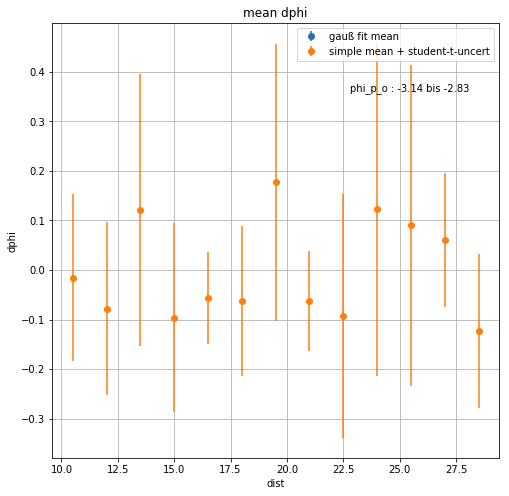

In [44]:
def Plot_mean_2bins_hist_dynamic(quantity = 'dphi',first = 'dist',second = 'phi_po',n_bin=20):
    ## define all the bins, edges of bins and dicts of bins, etc. 
    n_dist_bins = n_bin
    n_phi_bins = n_bin
    dist_binsize = event_radius/n_dist_bins
    phi_binsize = 2*np.pi/n_phi_bins
    dist_bins = np.array(range(0,n_dist_bins,1))
    phi_p_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_po_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_o_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    dist_bins_abs = np.array(range(0,n_dist_bins,1))*dist_binsize
    phi_p_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_po_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_o_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    bin_dict = {'phi_p' : phi_p_bins_abs,'dist' : dist_bins_abs, 'phi_p_o' : phi_po_bins_abs,'phi_o' : phi_o_bins_abs}
    M_mean = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_mean[:,:] = np.nan
    M_std = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_std[:,:] = np.nan
    M_uncert = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_uncert[:,:] = np.nan
    M_N = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    t1.set_index(['master_index'],drop = False,inplace = True);
    j = 0
    first_binsize = bin_dict[first][1]-bin_dict[first][0]
    second_binsize = bin_dict[second][1]-bin_dict[second][0]
    for first_bin in bin_dict[first]:
        i = 0
        for second_bin in bin_dict[second]:
            
            t1.set_index([first,second],drop = False,inplace = True)
            t1_filtered = t1[(t1[first] > first_bin) & (t1[first] < first_bin+first_binsize)
                     & (t1[second] > second_bin) & (t1[second] < second_bin+second_binsize)
                     & (np.isfinite(np.array(t1['dx'])))## here all the nans are also filtered away 
                        ];
            try:
                if quantity == 'dr':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    data= np.sqrt(dx**2+dy**2)
                elif quantity =='dr_parallel':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    phi = np.array(t1_filtered['phi'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
                elif quantity =='dr_antiparallel':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    phi = np.array(t1_filtered['phi'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
                elif quantity =='dr_p':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    phi = np.array(t1_filtered['phi_p'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
                else:
                    data = np.array(t1_filtered[quantity])
                N = len(data)
                M_N[i,j] = N
                if N>40:
                    n_bins = 100
                    ## fiting 
                    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
                    # Define model function to be used to fit to the data above:
                    def gauss(x, *p):
                        A, mu, sigma = p
                        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                    p0 = [0., 0.1, 1.]
                    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                    M_mean[i,j] = coeff[1]  # write the mean innto the matrix
                    M_std[i,j] = np.abs(coeff[2])
                    M_uncert[i,j] = np.abs(var_matrix[1,1])
                else:
                    #if j ==15:
                        #print('not enough counts',second,second_bin,first,first_bin)
                    M_mean[i,j] = np.nan
                    M_std[i,j] = np.nan
                    M_uncert[i,j] = np.nan
            except KeyError:
                #if j ==15:
                    #print('key error',second,second_bin,first,first_bin)
                M_mean[i,j] = np.nan
                M_std[i,j] = np.nan
                M_uncert[i,j] = np.nan
                M_N[i,j] = 0
            i+=1
        j+=1
    #print(M_mean)
    plt.figure()
    #plt.imshow(M_mean,cmap = 'bone',extent=[np.min(bin_dict[first]),np.max(bin_dict[first]),np.min(bin_dict[second]),np.max(bin_dict[second])])
    if np.min(M_mean) > -np.max(M_mean):
        edge_value = np.max(M_mean)
    else:
        edge_value = -np.min(M_mean)
    #plt.imshow(M_mean,cmap = 'seismic',vmin=-edge_value, vmax=edge_value)
    #plt.imshow(M_mean,cmap = 'gray') # for 'normal colored plot'
    masked_array = np.ma.array (M_mean, mask=np.isnan(M_mean))
    cmap=copy.copy(matplotlib.cm.bone)
    cmap.set_bad('red',0.2)
    #plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
    first_list_extended = list(bin_dict[first])
    second_list_extended = list(bin_dict[second])
    first_list_extended.append(bin_dict[first][-1]+bin_dict[first][1]-bin_dict[first][0])
    second_list_extended.append(bin_dict[second][-1]+bin_dict[second][1]-bin_dict[second][0])
    xticks = first_list_extended
    yticks = second_list_extended
    plt.pcolormesh(xticks, yticks, masked_array,cmap = cmap)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.colorbar()
    plt.title('mean '+quantity)
    plt.savefig('mean_'+quantity + '_2DHist_'+first +'_'+second + '_bins'+str(int(n_bin)))
    plt.show()
    
    plt.figure()
    plt.pcolormesh(xticks, yticks, M_N,cmap = 'gray')
    #plt.imshow(M_N,cmap = 'gray')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('#')
    plt.colorbar()
    plt.savefig('N_'+quantity + '_2DHist_'+first +'_'+second + '_bins'+str(int(n_bin)))
    plt.show()
    
    plt.figure()
    plt.pcolormesh(xticks, yticks, M_std,cmap = 'gray')
    #plt.imshow(M_std,cmap = 'gray')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('sigma of gaußfit')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.pcolormesh(xticks, yticks, M_uncert,cmap = 'gray')
    #plt.imshow(M_uncert,cmap = 'gray')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('uncertenty of mean via gaußfit, probalby not correct....')
    plt.colorbar()
    plt.show()
    
    return
#Plot_mean_2bins_hist_dynamic(quantity = 'dr_parallel',first = 'distance_ij',second = 'phi_p_o',n_bin = 10)

def Plot_mean_bin_hist_dynamic_2(quantity = 'dphi',first = 'distance_ij',second = 'phi_p_o',second_bin_index = 0,phi_bins=20,dist_bins=20):
    #do the selection here manually, cause otherwise it is to aufwändig
    n_dist_bins = dist_bins
    n_phi_bins = phi_bins
    dist_binsize = event_radius/n_dist_bins
    phi_binsize = 2*np.pi/n_phi_bins
    dist_bins = np.array(range(0,n_dist_bins,1))
    phi_p_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_po_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_o_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    dist_bins_abs = np.array(range(0,n_dist_bins,1))*dist_binsize
    phi_p_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_po_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_o_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    bin_dict = {'phi_p' : phi_p_bins_abs,'dist' : dist_bins_abs, 'phi_p_o' : phi_po_bins_abs,'phi_o' : phi_o_bins_abs}
    M_mean = np.zeros((len(bin_dict[first])))
    M_mean[:] = np.nan
    M_mean2 = np.zeros((len(bin_dict[first])))
    M_mean2[:] = np.nan
    M_std = np.zeros((len(bin_dict[first])))
    M_std[:] = np.nan
    M_uncert2 = np.zeros((len(bin_dict[first])))
    M_uncert2[:] = np.nan
    M_uncert = np.zeros((len(bin_dict[first])))
    M_uncert[:] = np.nan
    M_N = np.zeros((len(bin_dict[first])))
    t1.set_index(['master_index'],drop = False,inplace = True);
    j = 0
    first_binsize = bin_dict[first][1]-bin_dict[first][0]
    second_binsize = bin_dict[second][1]-bin_dict[second][0]
    second_bin = bin_dict[second][second_bin_index]
    for first_bin in bin_dict[first]:
        t1.set_index([first,second],drop = False,inplace = True)
        t1_filtered = t1[(t1[first] > first_bin) & (t1[first] < first_bin+first_binsize)
                    & (t1[second] > second_bin) & (t1[second] < second_bin+second_binsize)
                    & (np.isfinite(np.array(t1['dx'])))## here all the nans are also filtered away 
                    ];
        try:
            if quantity == 'dr':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                data= np.sqrt(dx**2+dy**2)
            elif quantity =='dr_parallel':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                phi = np.array(t1_filtered['phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
            elif quantity =='dr_antiparallel':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                phi = np.array(t1_filtered['phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
            elif quantity =='dr_p':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                phi = np.array(t1_filtered['phi_p'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
            else:
                data = np.array(t1_filtered[quantity])
            N = len(data)
            M_N[j] = N
            if N>40:
                n_bins = 100
                ## fiting 
                hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
                # Define model function to be used to fit to the data above:
                def gauss(x, *p):
                    A, mu, sigma = p
                    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                p0 = [0., 0.1, 1.]
                coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                M_mean[j] = coeff[1]  # write the mean innto the matrix
                M_std[j] = np.abs(coeff[2])
                M_uncert[j] = np.abs(var_matrix[1,1])
            else:
                M_mean[j] = np.nan
                M_std[j] = np.nan
                M_uncert[j] = np.nan
            M_mean2[j] = np.mean(data)
            M_uncert2[j] = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
        except KeyError:
            #if j ==15:
                #print('key error',second,second_bin,first,first_bin)
            M_mean[i,j] = np.nan
            M_std[i,j] = np.nan
            M_uncert[i,j] = np.nan
            M_N[i,j] = 0
        j+=1
    print('data has ',second,' between ',str(format(second_bin, '.3g')),' and ',str(format(second_bin+second_binsize, '.3g')))
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.errorbar(bin_dict[first],M_mean,yerr=M_uncert , fmt='o',label = 'gauß fit mean')
    plt.title('mean '+quantity) #+'Hist_where '+ second+ '_between_'+str(second_bin)+'_and_'+str(second_bin+second_binsize)
    plt.errorbar(bin_dict[first],M_mean2,yerr=M_uncert2, fmt = 'o', label = 'simple mean + student-t-uncert')
    plt.ylabel(quantity)
    plt.xlabel(first)
    plt.grid()
    plt.legend()
    ax.text(0.8, 0.85,second+ ' : '+str(format(second_bin, '.3g'))+' bis '+str(format(second_bin+second_binsize, '.3g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    plt.savefig('mean_'+quantity + '_'+second +'_' + str(int(second_bin_index)) +'bin' ) #+'Hist_where '+ second+ '_between_'+str(second_bin)+'_and_'+str(second_bin+second_binsize)
    plt.show()
    return
Plot_mean_bin_hist_dynamic_2(quantity = 'dphi',first = 'dist',second = 'phi_p_o',second_bin_index = 0,phi_bins=20,dist_bins=20)
#interact(Plot_mean_bin_hist_dynamic_2,quantity = 'dphi',first = 'phi_p_o',second = 'distance_ij',second_bin_index = (0,20),phi_bins=(6,20,2),dist_bins=(6,20,2))

def Plot_mean_bin_hist_dynamic(quantity = 'dphi',first = 'distance_ij',n_bin=20):
    #do the selection here manually, cause otherwise it is to aufwändig
    n_dist_bins = n_bin
    n_phi_bins = n_bin
    dist_binsize = event_radius/n_dist_bins
    phi_binsize = 2*np.pi/n_phi_bins
    dist_bins = np.array(range(0,n_dist_bins,1))
    phi_p_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_po_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_o_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    dist_bins_abs = np.array(range(0,n_dist_bins,1))*dist_binsize
    phi_p_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_po_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_o_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    bin_dict = {'phi_p' : phi_p_bins_abs,'distance_ij' : dist_bins_abs, 'phi_p_o' : phi_po_bins_abs,'phi_o' : phi_o_bins_abs}
    M_mean = np.zeros((len(bin_dict[first])))
    M_mean[:] = np.nan
    M_mean2 = np.zeros((len(bin_dict[first])))
    M_mean2[:] = np.nan
    M_std = np.zeros((len(bin_dict[first])))
    M_std[:] = np.nan
    M_uncert2 = np.zeros((len(bin_dict[first])))
    M_uncert2[:] = np.nan
    M_uncert = np.zeros((len(bin_dict[first])))
    M_uncert[:] = np.nan
    M_N = np.zeros((len(bin_dict[first])))
    t1.set_index(['master_index'],drop = False,inplace = True);
    j = 0
    first_binsize = bin_dict[first][1]-bin_dict[first][0]
    for first_bin in bin_dict[first]:
        t1.set_index([first],drop = False,inplace = True)
        t1_filtered = t1[(t1[first] > first_bin) & (t1[first] < first_bin+first_binsize)
                    & (np.isfinite(np.array(t1['dx'])))## here all the nans are also filtered away 
                    ];
        try:
            if quantity == 'dr':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                data= np.sqrt(dx**2+dy**2)
            elif quantity =='dr_parallel':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                phi = np.array(t1_filtered['phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
            elif quantity =='dr_antiparallel':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                phi = np.array(t1_filtered['phi'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
            elif quantity =='dr_p':
                dx = np.array(t1_filtered['dx'])
                dy = np.array(t1_filtered['dy'])
                phi = np.array(t1_filtered['phi_p'])
                data = np.zeros(len(dx))
                for k in range(len(dx)):
                    data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
            else:
                data = np.array(t1_filtered[quantity])
            N = len(data)
            M_N[j] = N
            if N>40:
                n_bins = 100
                ## fiting 
                hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
                # Define model function to be used to fit to the data above:
                def gauss(x, *p):
                    A, mu, sigma = p
                    return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                p0 = [0., 0.1, 1.]
                coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                M_mean[j] = coeff[1]  # write the mean innto the matrix
                M_std[j] = np.abs(coeff[2])
                M_uncert[j] = np.abs(var_matrix[1,1])
            else:
                M_mean[j] = np.nan
                M_std[j] = np.nan
                M_uncert[j] = np.nan
            M_mean2[j] = np.mean(data)
            M_uncert2[j] = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
        except KeyError:
            #if j ==15:
                #print('key error',second,second_bin,first,first_bin)
            M_mean[i,j] = np.nan
            M_std[i,j] = np.nan
            M_uncert[i,j] = np.nan
            M_N[i,j] = 0
        j+=1
    plt.figure(dpi = 100)
    plt.errorbar(bin_dict[first],M_mean,yerr=M_uncert , fmt='o',label = 'gauß fit')
    plt.title('mean '+quantity)
    plt.errorbar(bin_dict[first],M_mean2,yerr=M_uncert2, fmt = 'o', label = 'simple mean + student-t-uncert')
    plt.ylabel(quantity)
    plt.xlabel(first)
    plt.grid()
    plt.legend()
    plt.show()
    return
#Plot_mean_bin_hist_dynamic(quantity = 'dphi',first = 'distance_ij',second = 'phi_p_o',i = 0,n_bin=20)
#interact(Plot_mean_bin_hist_dynamic,quantity = 'dphi',first = 'phi_p_o',n_bin=(6,20,2))


In [416]:
plt.pcolor?

/Users/Nic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


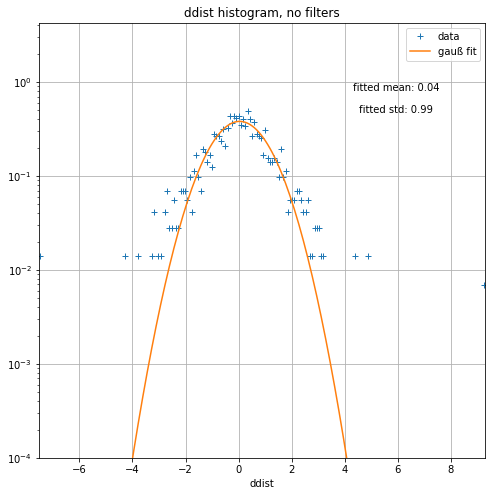

In [45]:
## V2---------
def Plot_unfiltered_quantity_hist(quantity,logy = 'off'):
    t1.set_index(['master_index'],drop = False,inplace = True);
    if quantity == 'dr':
        t1_filtered = t1[np.isfinite(np.array(t1['dx']))]
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        data= np.sqrt(dx**2+dy**2)
    elif quantity =='dr_parallel':
        t1_filtered = t1[np.isfinite(np.array(t1['dx']))]
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    elif quantity =='dr_antiparallel':
        t1_filtered = t1[np.isfinite(np.array(t1['dx']))]
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
    elif quantity =='dr_p':
        t1_filtered = t1[np.isfinite(np.array(t1['dx']))]
        dx = np.array(t1_filtered['dx'])
        dy = np.array(t1_filtered['dy'])
        phi = np.array(t1_filtered['phi_p'])
        data = np.zeros(len(dx))
        for k in range(len(dx)):
            data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
    else:
        t1_filtered = t1[np.isfinite(np.array(t1[quantity]))]
        data = np.array(t1_filtered[quantity])
    N = len(data)
    n_bins = 200
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    mean = coeff[1]  # write the mean innto the matrix
    std = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    mean2 = np.mean(data)
    uncert2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(bin_edges_mid, hist,label = 'data',marker = '+',linestyle = 'None')
        ax.semilogy(bin_centres, hist_fit, label='gauß fit')
        plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else:
        ax.plot(bin_centres, hist_fit, label='gauß fit')
        ax.hist(data,bins = n_bins,normed=True)
    ax.legend()
    ax.grid()
    plt.title(quantity+' histogram, no filters')
    ax.text(0.8, 0.85,'fitted mean: '+str(format(mean, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    ax.text(0.8, 0.8,'fitted std: '+str(format(std, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    plt.xlabel(quantity)
    plt.savefig(quantity + '_histogramm_unfilterd')
    fig.show()
    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', np.abs(coeff[2]))
    return
Plot_unfiltered_quantity_hist('ddist',logy='on')

In [46]:
#### pair analysis of dphi_o to maybe get some HD out of it
HD_plot_dist = 13
def Plot_dphi_o_HD_events_hist(logy = 'off'):
    n_dist_bins = 20   # from 10/11 to 12/13 seems to be the interessting region
    n_phi_bins = 8
    t1.set_index(['master_index'],drop = False,inplace = True)
    ## case where the two point into the same direction and are in the same plane perpendicular to phi
    t1_filtered1 = t1[(t1['phi_o'] > -np.pi/8) & (t1['phi_o'] < np.pi/8)
                     & (t1['phi_p_o'] > -np.pi*5/8) & (t1['phi_p_o'] < -np.pi*3/8)
                     & (t1['dist'] < HD_plot_dist)    #& (t1['distance_ij'] > 10)
                     & (np.isfinite(np.array(t1['dphi_o'])))    ## here all the nans are also filtered away 
                     & (np.array(t1['master_index'])%2 == 0)   # look only for pairs
                    ];
    t1_filtered2 = t1[(t1['phi_o'] > -np.pi/8) & (t1['phi_o'] < np.pi/8)
                     & (t1['phi_p_o'] > np.pi*3/8) & (t1['phi_p_o'] < np.pi*5/8)
                     & (t1['dist'] < HD_plot_dist) #& (t1['distance_ij'] > 10)
                     & (np.isfinite(np.array(t1['dphi_o'])))## here all the nans are also filtered away 
                     & (np.array(t1['master_index'])%2 == 0)   # look only for pairs
                    ];
    data = np.concatenate((np.array(t1_filtered1.dphi_o),-np.array(t1_filtered2.dphi_o)),0)
    #data = np.array(t1_filtered2.dphi)
    N = len(data)
    print('N',N)
    n_bins = 100
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    mean = coeff[1]  # write the mean innto the matrix
    std = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    mean_simple_1 = np.mean(data)
    uncert_simple_1 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(bin_edges_mid, hist,label = 'data',marker = '+',linestyle = 'None')
        ax.semilogy(bin_centres, hist_fit, label='gauß fit')
        plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else:
        ax.plot(bin_centres, hist_fit, label='gauß fit')
        ax.hist(data,bins = n_bins,normed=True)
    ax.legend()
    ax.grid()
    plt.title('dphi_o for parallel orient. / pos in plane perp. to orient.')
    ax.text(0.8, 0.85,'fitted mean: '+str(format(mean, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    ax.text(0.8, 0.8,'fitted std: '+str(format(std, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    ax.text(0.8, 0.75,'simple mean: '+str(format(mean_simple_1, '.2g'))+'$\pm$ ' + str(format(uncert_simple_1, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    plt.xlabel('dphi_o')
    plt.savefig('dphi_o_parralel_plane_HD_dist'+str(format(HD_plot_dist, '.2g')))
    fig.show()
    #print('Fitted mean = ', coeff[1])
    #print('Fitted standard deviation = ', np.abs(coeff[2]))
    
    ## case where the two point into opposit directions and are in the same plane perpendicular to phi
    # here dphi_o should be 0 whereas dphi1 = - dphi2 should be non zero
    # therefore 4 cases have to be differeciated two state cases and the two particles respectivly
    t1_filtered11 = t1[((t1['phi_o'] > np.pi*7/8) & (t1['phi_o'] < np.pi)
                        | (t1['phi_o'] > -np.pi) & (t1['phi_o'] < -np.pi*7/8))
                     & (t1['phi_p_o'] > -np.pi*5/8) & (t1['phi_p_o'] < -np.pi*3/8)
                     & (t1['dist'] < HD_plot_dist)    #& (t1['distance_ij'] > 10)
                     & (np.isfinite(np.array(t1['dphi_o'])))    ## here all the nans are also filtered away 
                     & (np.array(t1['master_index'])%2 == 0)   # look only for pairs
                    ];
    t1_filtered12 = t1[((t1['phi_o'] > np.pi*7/8) & (t1['phi_o'] < np.pi)
                        | (t1['phi_o'] > -np.pi) & (t1['phi_o'] < -np.pi*7/8))
                     & (t1['phi_p_o'] > np.pi*3/8) & (t1['phi_p_o'] < np.pi*5/8)
                     & (t1['dist'] < HD_plot_dist)    #& (t1['distance_ij'] > 10)
                     & (np.isfinite(np.array(t1['dphi_o'])))    ## here all the nans are also filtered away 
                     & (np.array(t1['master_index'])%2 == 1)   # look only for pairs
                    ];
    t1_filtered21 = t1[((t1['phi_o'] > np.pi*7/8) & (t1['phi_o'] < np.pi)
                        | (t1['phi_o'] > -np.pi) & (t1['phi_o'] < -np.pi*7/8))
                     & (t1['phi_p_o'] > np.pi*3/8) & (t1['phi_p_o'] < np.pi*5/8)
                     & (t1['dist'] < HD_plot_dist) #& (t1['distance_ij'] > 10)
                     & (np.isfinite(np.array(t1['dphi_o'])))## here all the nans are also filtered away 
                     & (np.array(t1['master_index'])%2 == 0)   # look only for pairs
                    ];
    t1_filtered22 = t1[((t1['phi_o'] > np.pi*7/8) & (t1['phi_o'] < np.pi)
                        | (t1['phi_o'] > -np.pi) & (t1['phi_o'] < -np.pi*7/8))
                     & (t1['phi_p_o'] > -np.pi*5/8) & (t1['phi_p_o'] < -np.pi*3/8)
                     & (t1['dist'] < HD_plot_dist) #& (t1['distance_ij'] > 10)
                     & (np.isfinite(np.array(t1['dphi_o'])))## here all the nans are also filtered away 
                     & (np.array(t1['master_index'])%2 == 1)   # look only for pairs
                    ];
    data = np.concatenate((np.array(t1_filtered11.dphi),-np.array(t1_filtered12.dphi),-np.array(t1_filtered21.dphi),np.array(t1_filtered22.dphi)),0)
    #data = -np.array(t1_filtered11.dphi)
    N = len(data)
    print('N',N)
    n_bins = 100
    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
    # Define model function to be used to fit to the data above:
    def gauss(x, *p):
        A, mu, sigma = p
        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
    p0 = [0., 0.1, 1.]
    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
    mean = coeff[1]  # write the mean innto the matrix
    std = np.abs(coeff[2])
    uncert = np.abs(var_matrix[1,1])
    mean_simple_2 = np.mean(data)
    uncert_simple_2 = np.std(data)/np.sqrt(N)* stats.t.ppf(0.95,N)
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1, 1, 1)
    hist_fit = gauss(bin_centres, *coeff)
    
    bin_size = bin_edges[1]-bin_edges[0]
    bin_edges_mid = np.array(bin_edges)+bin_size/2
    bin_edges_mid = list(bin_edges_mid)
    bin_edges_mid.pop()
    #ax.scatter(bin_edges_mid, hist)
    if logy == 'on':
        ax.semilogy(bin_edges_mid, hist,label = 'data',marker = '+',linestyle = 'None')
        ax.semilogy(bin_centres, hist_fit, label='gauß fit')
        plt.xlim(np.min(data),np.max(data))
        plt.ylim(ymin=10**-4)
    else:
        ax.plot(bin_centres, hist_fit, label='gauß fit')
        ax.hist(data,bins = n_bins,normed=True)
    ax.legend()
    ax.grid()
    plt.title('dphi for parallel orient. / pos in plane perp. to orient.')
    ax.text(0.8, 0.85,'fitted mean: '+str(format(mean, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    ax.text(0.8, 0.8,'fitted std: '+str(format(std, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    ax.text(0.8, 0.75,'simple mean: '+str(format(mean_simple_2, '.2g'))+'$\pm$ ' + str(format(uncert_simple_2, '.2g')),
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax.transAxes)
    plt.xlabel('dphi')
    plt.savefig('dphi_o_antiparallel_plane_HD_dist'+str(format(HD_plot_dist, '.2g')))
    fig.show()
    return
Plot_dphi_o_HD_events_hist(logy = 'off')

#||||||||||1==1 & 2==2|   oder in pandas


N 1


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 800.

In [58]:
def Plot_mean_phi_XYdensitiy():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    
    
    
    
    plt.figure(figsize = (10,7),dpi = 200)
    
    
    
    
    
    
    
    
    
    plt.hist2d(Tracked_particles['x'],Tracked_particles['y'],cmap = 'gray',bins = 100)
    
    return

def Plot_mean_phi_XY(quantity = 'phi',first = 'x',second = 'phi_po',n_bin=20):
    ## define all the bins, edges of bins and dicts of bins, etc. 
    n_xy_bins = 512
    n_dist_bins = n_bin
    n_phi_bins = n_bin
    dist_binsize = event_radius/n_dist_bins
    phi_binsize = 2*np.pi/n_phi_bins
    x_binsize = 1
    dist_bins = np.array(range(0,n_dist_bins,1))
    phi_p_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_po_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    phi_o_bins = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))
    x_bins = np.array(range)
    dist_bins_abs = np.array(range(0,n_dist_bins,1))*dist_binsize
    phi_p_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_po_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    phi_o_bins_abs = np.array(range(-n_phi_bins//2,n_phi_bins//2,1))/n_phi_bins*2*np.pi
    
    
    
    bin_dict = {'phi_p' : phi_p_bins_abs,'dist' : dist_bins_abs,'x':x_bins_abs,'y':x_bins_abs, 'phi_p_o' : phi_po_bins_abs,'phi_o' : phi_o_bins_abs}
    M_mean = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_mean[:,:] = np.nan
    M_std = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_std[:,:] = np.nan
    M_uncert = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    M_uncert[:,:] = np.nan
    M_N = np.zeros((len(bin_dict[first]),len(bin_dict[second])))
    t1.set_index(['master_index'],drop = False,inplace = True);
    j = 0
    first_binsize = bin_dict[first][1]-bin_dict[first][0]
    second_binsize = bin_dict[second][1]-bin_dict[second][0]
    for first_bin in bin_dict[first]:
        i = 0
        for second_bin in bin_dict[second]:
            t1.set_index([first,second],drop = False,inplace = True)
            t1_filtered = t1[(t1[first] > first_bin) & (t1[first] < first_bin+first_binsize)
                     & (t1[second] > second_bin) & (t1[second] < second_bin+second_binsize)
                     & (np.isfinite(np.array(t1['dx'])))## here all the nans are also filtered away 
                        ];
            try:
                if quantity == 'dr':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    data= np.sqrt(dx**2+dy**2)
                elif quantity =='dr_parallel':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    phi = np.array(t1_filtered['phi'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
                elif quantity =='dr_antiparallel':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    phi = np.array(t1_filtered['phi'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]+np.pi/2),np.cos(phi[k]+np.pi/2)])
                elif quantity =='dr_p':
                    dx = np.array(t1_filtered['dx'])
                    dy = np.array(t1_filtered['dy'])
                    phi = np.array(t1_filtered['phi_p'])
                    data = np.zeros(len(dx))
                    for k in range(len(dx)):
                        data[k] = -np.dot([dx[k],dy[k]],[np.sin(phi[k]),np.cos(phi[k])])
                else:
                    data = np.array(t1_filtered[quantity])
                N = len(data)
                M_N[i,j] = N
                if N>40:
                    n_bins = 100
                    ## fiting 
                    hist, bin_edges = np.histogram(data, density=True,bins = n_bins)
                    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2
                    
                    # Define model function to be used to fit to the data above:
                    def gauss(x, *p):
                        A, mu, sigma = p
                        return A*np.exp(-(x-mu)**2/(2.*sigma**2))
                    # p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
                    p0 = [0., 0.1, 1.]
                    coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)
                    M_mean[i,j] = coeff[1]  # write the mean innto the matrix
                    M_std[i,j] = np.abs(coeff[2])
                    M_uncert[i,j] = np.abs(var_matrix[1,1])
                else:
                    #if j ==15:
                        #print('not enough counts',second,second_bin,first,first_bin)
                    M_mean[i,j] = np.nan
                    M_std[i,j] = np.nan
                    M_uncert[i,j] = np.nan
            except KeyError:
                #if j ==15:
                    #print('key error',second,second_bin,first,first_bin)
                M_mean[i,j] = np.nan
                M_std[i,j] = np.nan
                M_uncert[i,j] = np.nan
                M_N[i,j] = 0
            i+=1
        j+=1
    #print(M_mean)
    plt.figure()
    #plt.imshow(M_mean,cmap = 'bone',extent=[np.min(bin_dict[first]),np.max(bin_dict[first]),np.min(bin_dict[second]),np.max(bin_dict[second])])
    if np.min(M_mean) > -np.max(M_mean):
        edge_value = np.max(M_mean)
    else:
        edge_value = -np.min(M_mean)
    #plt.imshow(M_mean,cmap = 'seismic',vmin=-edge_value, vmax=edge_value)
    #plt.imshow(M_mean,cmap = 'gray') # for 'normal colored plot'
    masked_array = np.ma.array (M_mean, mask=np.isnan(M_mean))
    cmap=copy.copy(matplotlib.cm.bone)
    cmap.set_bad('red',0.2)
    #plt.imshow(masked_array, interpolation='nearest', cmap=cmap)
    first_list_extended = list(bin_dict[first])
    second_list_extended = list(bin_dict[second])
    first_list_extended.append(bin_dict[first][-1]+bin_dict[first][1]-bin_dict[first][0])
    second_list_extended.append(bin_dict[second][-1]+bin_dict[second][1]-bin_dict[second][0])
    xticks = first_list_extended
    yticks = second_list_extended
    plt.pcolormesh(xticks, yticks, masked_array,cmap = cmap)
    plt.xlabel(first)
    plt.ylabel(second)
    plt.colorbar()
    plt.title('mean '+quantity)
    plt.savefig('mean_'+quantity + '_2DHist_'+first +'_'+second + '_bins'+str(int(n_bin)))
    plt.show()
    
    plt.figure()
    plt.pcolormesh(xticks, yticks, M_N,cmap = 'gray')
    #plt.imshow(M_N,cmap = 'gray')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('#')
    plt.colorbar()
    plt.savefig('N_'+quantity + '_2DHist_'+first +'_'+second + '_bins'+str(int(n_bin)))
    plt.show()
    
    plt.figure()
    plt.pcolormesh(xticks, yticks, M_std,cmap = 'gray')
    #plt.imshow(M_std,cmap = 'gray')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('sigma of gaußfit')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.pcolormesh(xticks, yticks, M_uncert,cmap = 'gray')
    #plt.imshow(M_uncert,cmap = 'gray')
    plt.xlabel(first)
    plt.ylabel(second)
    plt.title('uncertenty of mean via gaußfit, probalby not correct....')
    plt.colorbar()
    plt.show()
    return
#Plot_mean_2bins_hist_dynamic(quantity = 'dr_parallel',first = 'distance_ij',second = 'phi_p_o',n_bin = 10)



def Plot_position_desity():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    plt.figure(figsize = (10,7),dpi = 200)
    plt.hist2d(Tracked_particles['x'],Tracked_particles['y'],cmap = 'gray',bins = 100)
    plt.title('positional density for events')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar()
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/XYdensity')
    plt.show()
    return
#Plot_position_desity()

In [48]:
t1.head()

Unnamed: 0           x           y       phi  \
master_index                                                 
0                      0  377.195122  211.536585  2.326241   
1                      1  367.012658  233.044304 -2.294178   
2                      2  375.314286  212.182857  2.405017   
3                      3  366.949367  234.500000 -2.723933   
4                      4  373.825137  213.136612  2.345197   

                                                           file  file_counter  \
master_index                                                                    
0             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
1             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
2             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
3             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   
4             /Users/Nic/Documents/tmp_Messdaten_storage/JP_...             0   

              frame_rel      x_rel     y_rel                  udlr  \
master_index                                                         
0                     7   9.195122  9.536585  [220, 202, 368, 386]   
1                     7  10.012658  9.044304  [242, 224, 357, 375]   
2                     8   9.314286  9.182857  [221, 203, 366, 384]   
3                     8   9.949367  9.500000  [243, 225, 357, 375]   
4                     9   9.825137  9.136612  [222, 204, 364, 382]   

                 ...          phi_p  particle        dx        dy     ddist  \
master_index     ...                                                          
0                ...      -0.442169         0       NaN       NaN       NaN   
1                ...       2.699424         1       NaN       NaN       NaN   
2                ...      -0.358613         0 -1.880836  0.646272  0.036998   
3                ...       2.782980         1 -0.063291  1.455696  0.036998   
4                ...      -0.257665         0 -1.489149  0.953755  0.497779   

                  dphi    dphi_o    dphi_p  dphi_p_o  dphi_o_real  
master_index                                                       
0                  NaN       NaN       NaN       NaN          NaN  
1                  NaN       NaN       NaN       NaN          NaN  
2             0.078777  0.508532  0.083556  0.004779     0.508532  
3            -0.429755  0.508532  0.083556  0.513311    -0.508532  
4            -0.059821 -0.224696  0.100948  0.160769    -0.224696  

[5 rows x 27 columns]

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/Nicola/Desktop/tmp/Box_Analyse/phi_dist.png'

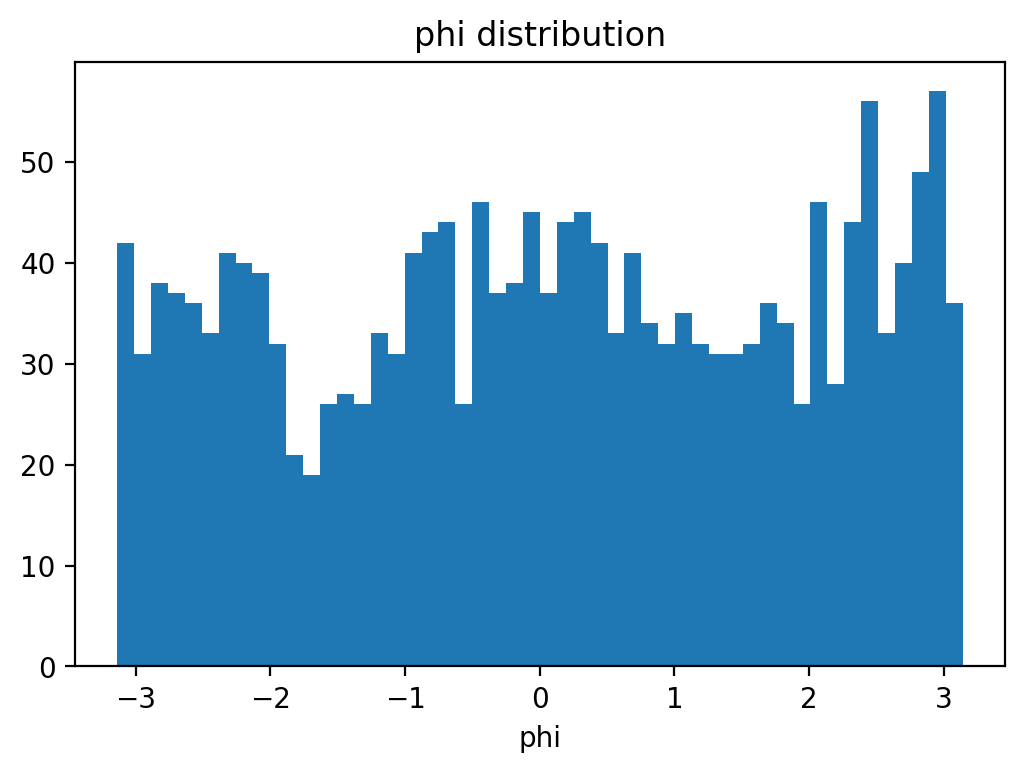

In [49]:
##########  -------------------  all the plot functions -----------------------------

#----basic plots-----------------------
Plot_phi_dist()   # plots the overall phi dist
#Plot_position_desity()  # plots the postion destity of events
#Plot_state_dist()  # plots the single double events dist, double -> to close for simle tracking
#Plot_interparticle_distance_dist()  # plot the overall interparticle distance
#Plot_phi_o_vs_distance()   
#Plot_phi_p()
#Plot_phi_po()
#Plot_bin_hist_2D_phi_po_vs_dist()
#-------------------------

#----displacement plots----------------------very old stuff-acts on all frames befor all kind of filtering is done---------------------------------------------------------------
#Plot_phi_displacement_hist(5,5)        ### plots dphi by dist and phi_po bin
#interact(Plot_phi_displacement_hist,dist_bin = (0,n_dist_bins),phi_po_bin = (0,n_phi_bins))
#interact(Fit_phi_displacement_hist,dist_bin = (0,n_dist_bins),phi_po_bin = (0,n_phi_bins))
#Plot_displacement_hist('dr',n_bins = 150,fit =True,mode = 'normal')    # here all d's can be shown, unfiltered
#Plot_disp_along_phi()   # plots the displacement pfojeted on the orienteaition of the particle, which gives the phoretic velocity
#Plot_disp_along_phi_p()
#Plot_mean_bin_dist(quantity = 'dr_p',first = 'dist_bin',second = 'phi_po_bin')    # plot the means a displacemnet quantity aginst two bins
#Plot_binned_displacement_hist(quantity = 'dphi',first = 'dist_bin',i = 0,second = 'phi_po_bin',j = 0,bins = n_bins)
#interact(Plot_binned_displacement_hist,quantity = 'dr_p',first = 'dist_bin',i = (0,20),second = 'phi_po_bin',j = (0,20),n_bins = 50)
#------------------------------------------------------------------------------------------------------------
#Plot_phi_dist()   # plots the overall phi dist
#Plot_position_desity()  # plots the postion destity of events
#Plot_state_dist()  # plots the single double events dist, double -> to close for simle tracking
#Plot_interparticle_distance_dist_weighted()  # plot the overall interparticle distance
#interact(Plot_binned_displacement_hist,quantity = 'dr_p',first = 'dist_bin',i = (0,20),second = 'phi_po_bin',j = (0,20),n_bins = (20,150))
#Plot_mean_2bins_hist(quantity = 'dphi',first = 'phi_p_bin',second = 'phi_po_bin')    # plot the means a displacemnet quantity aginst two bins
#Plot_disp_along_phi()   # plots the displacement pfojeted on the orienteaition of the particle, which gives the phoretic velocity
#Plot_mean_bin_hist(quantity = 'dx',first = 'phi_po_bin')

######----V2--------------------------------------------------------------
#Plot_filterd_hist('dx','phi','distance_ij',first_value = 0,second_value = 15,first_binsize = 0.5,second_binsize = 3)
#interact(Plot_filterd_hist,quantity = 'dx',first = 'phi',second = 'distance_ij',first_value = '0',second_value = '0',first_binsize = '0',second_binsize = '0')  

#Plot_mean_2bins_hist_dynamic(quantity = 'ddist',first = 'distance_ij',second = 'phi_o',n_bin = 14)

#Plot_mean_bin_hist_dynamic(quantity = 'dphi',first = 'distance_ij',n_bin=20)
#interact(Plot_mean_bin_hist_dynamic,quantity = 'dphi',first = 'phi_p_o',n_bin=(6,20,2))

#Plot_mean_bin_hist_dynamic_2(quantity = 'dr_p',first = 'phi_p_o',second = 'distance_ij',second_bin_index = 7,phi_bins=10,dist_bins = 20)
#interact(Plot_mean_bin_hist_dynamic_2,quantity = 'dphi',first = 'phi_p_o',second = 'distance_ij',second_bin_index = (0,20),phi_bins=(6,20,2),dist_bins=(6,20,2))

#Plot_unfiltered_quantity_hist('dphi_p_o',logy='on')





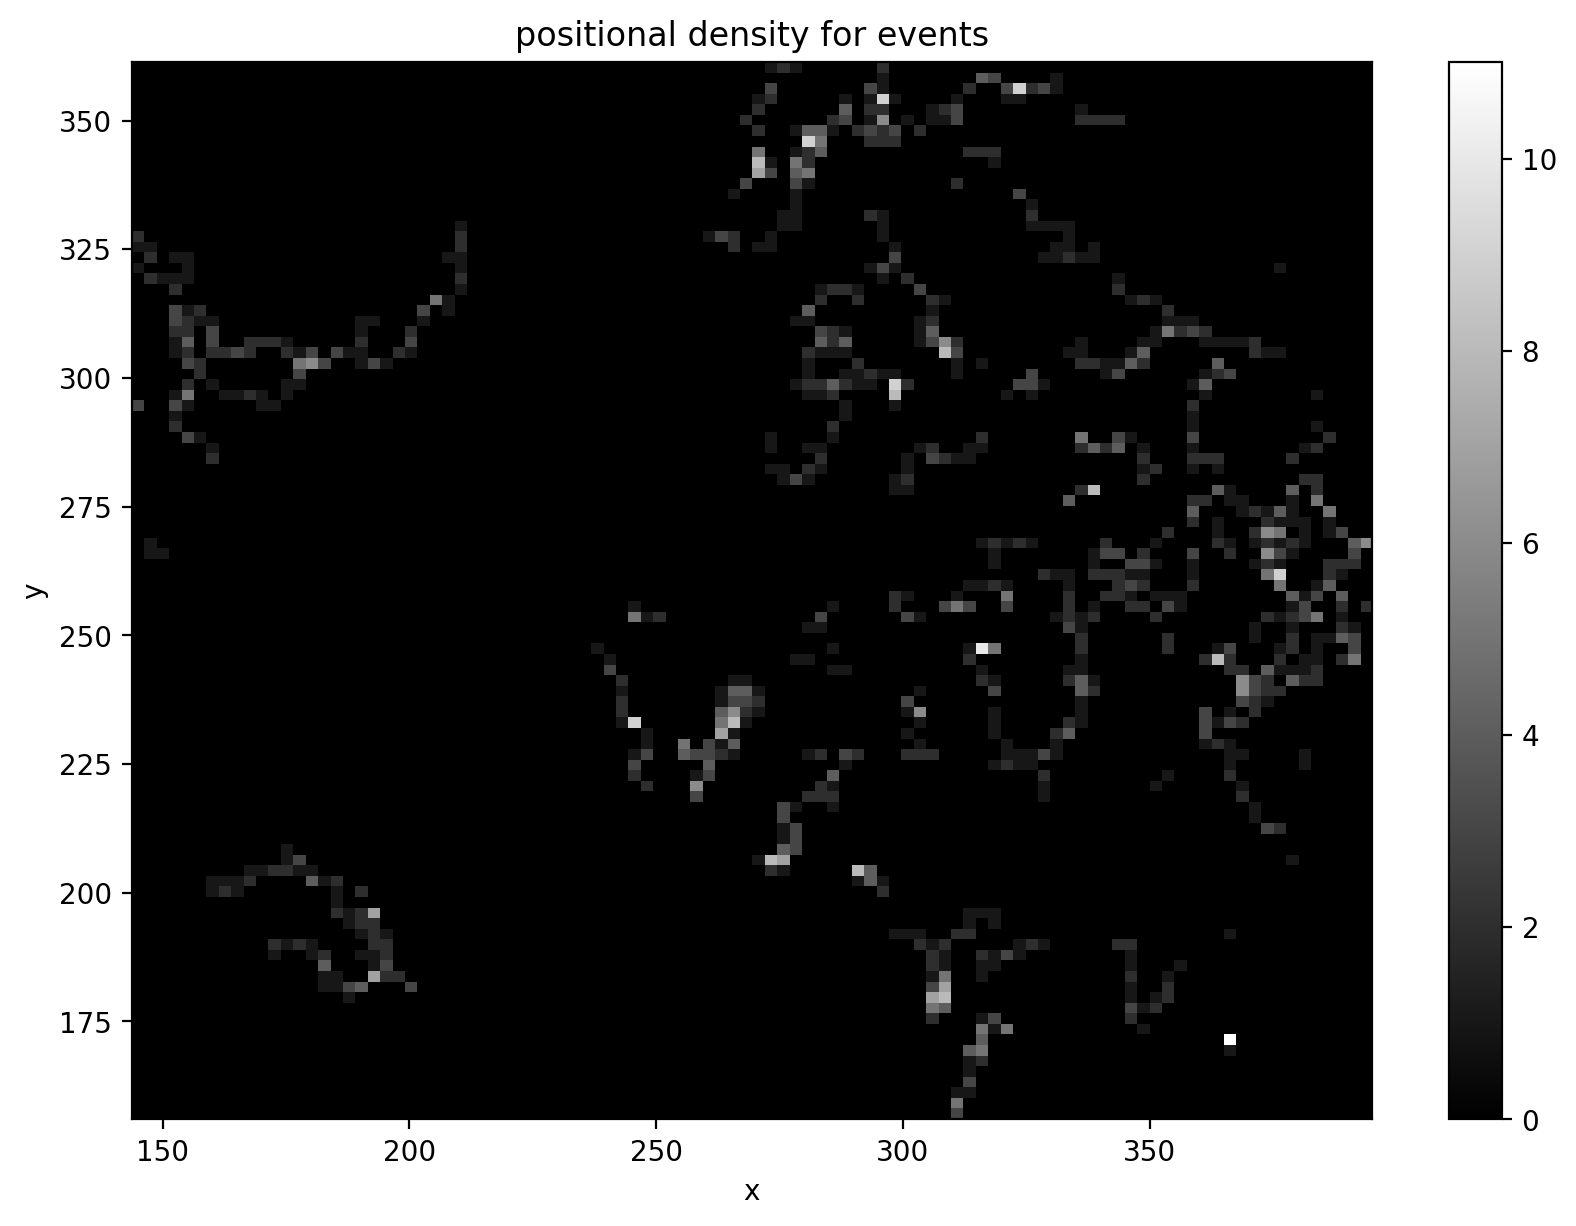

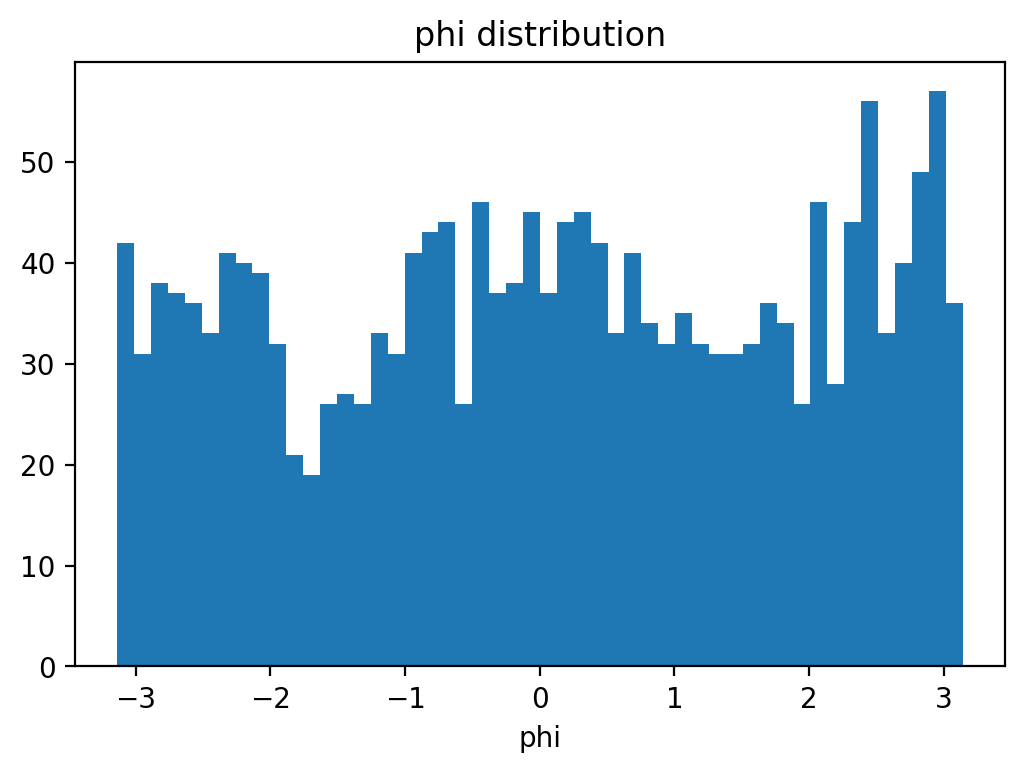

/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:53: FutureWarning: 'master_index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
/Users/Nic/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


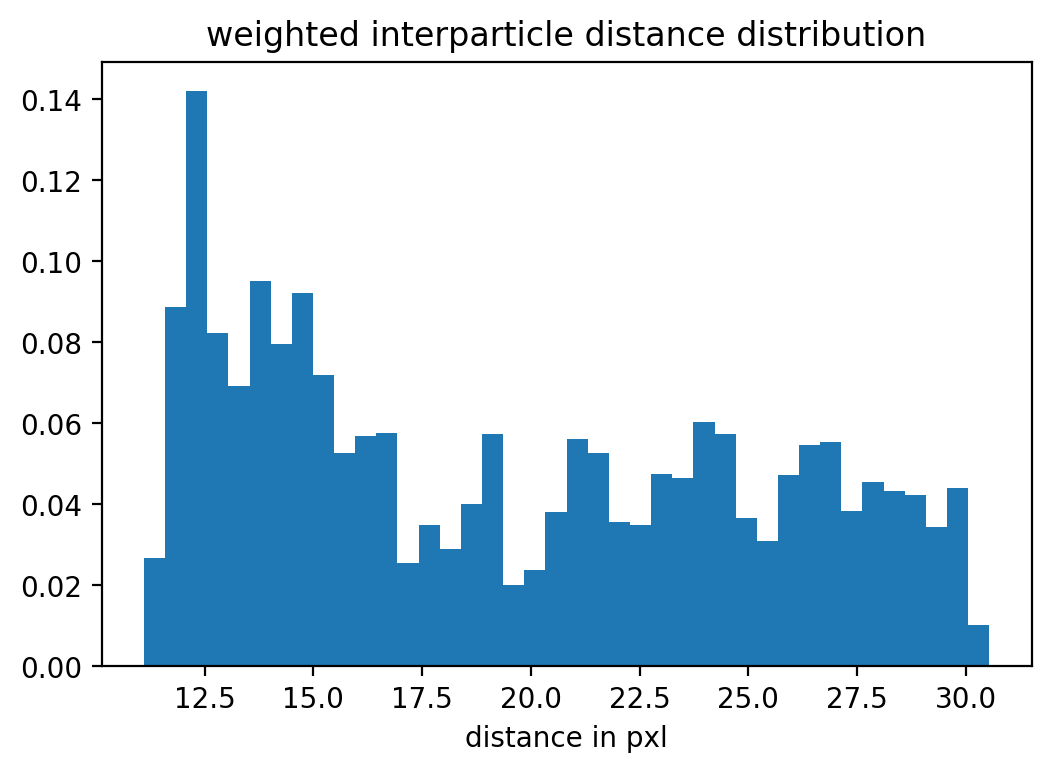

/Users/Nic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


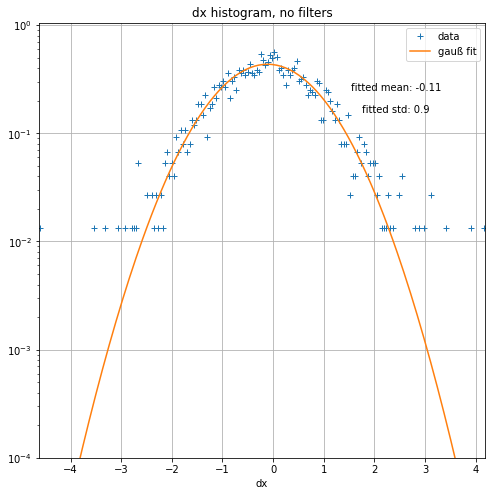

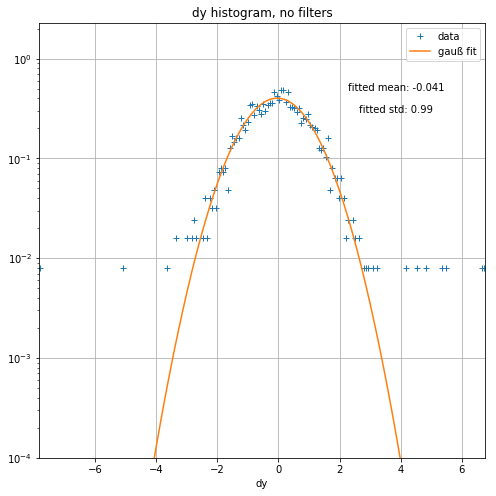

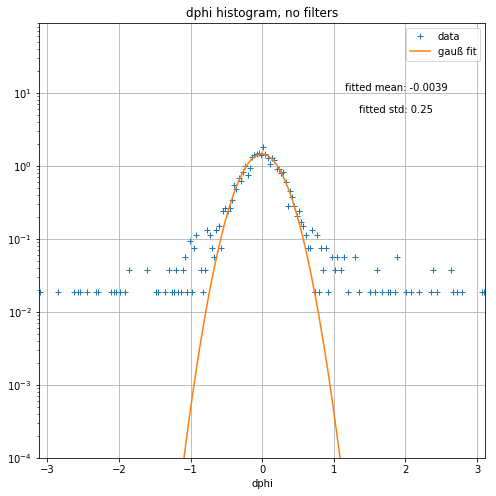

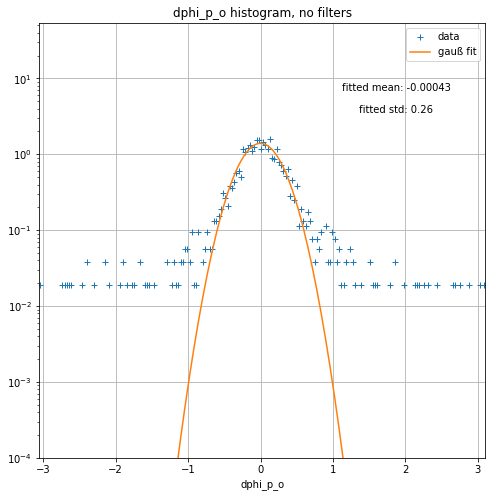

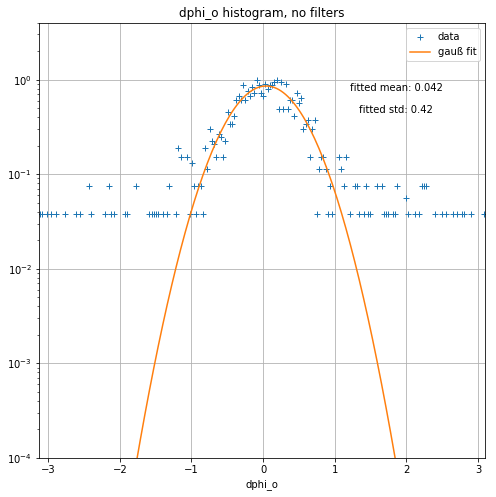

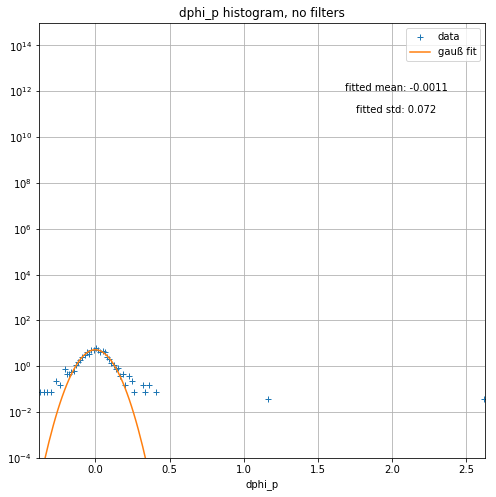

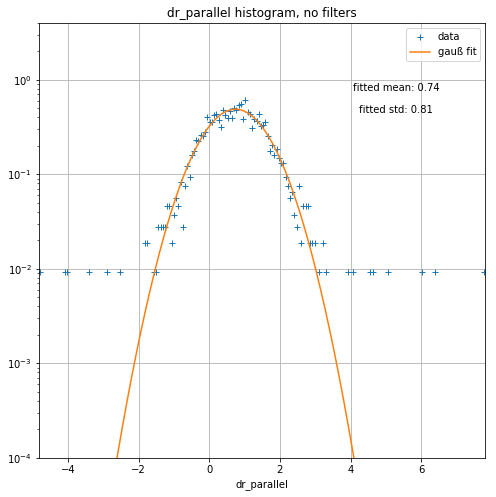

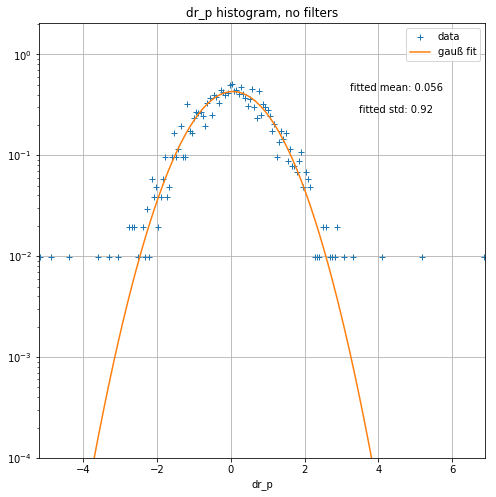

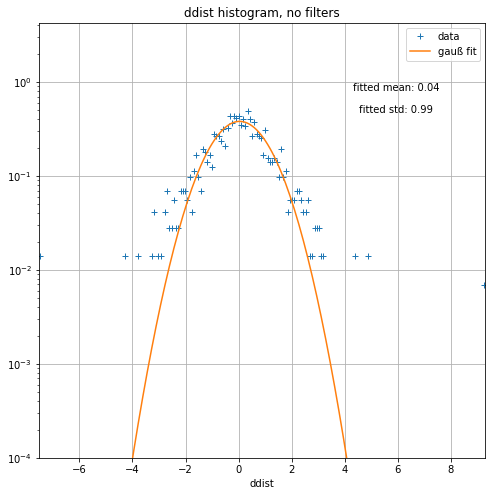

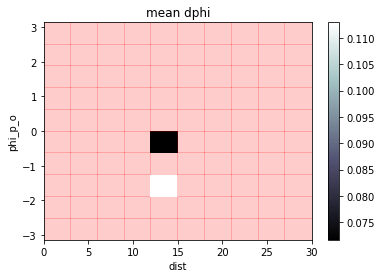

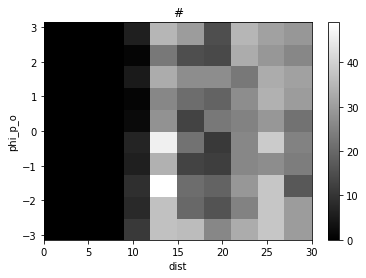

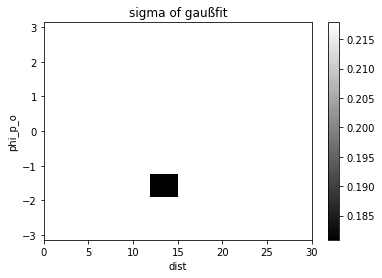

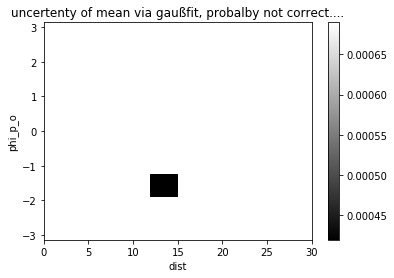

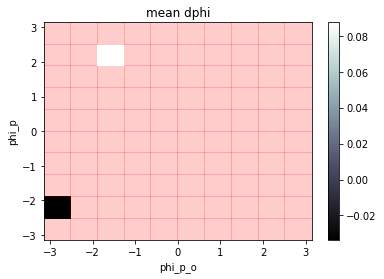

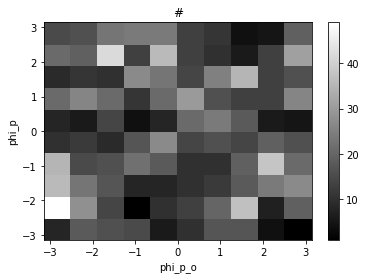

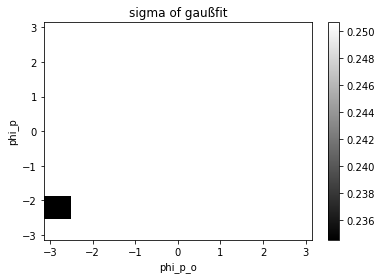

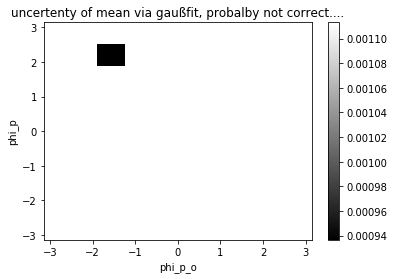

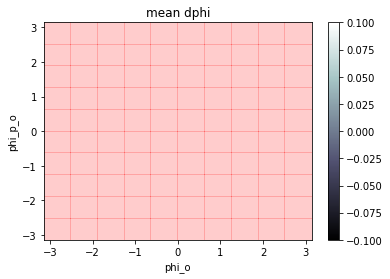

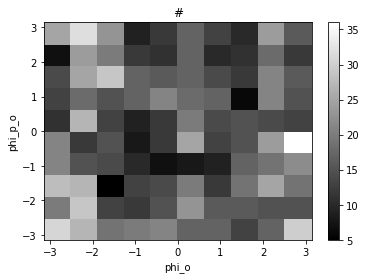

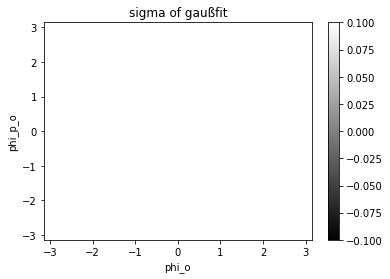

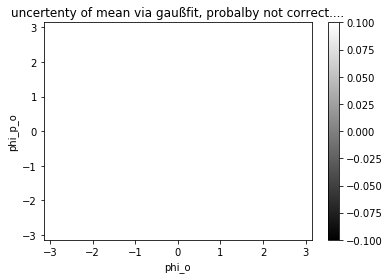

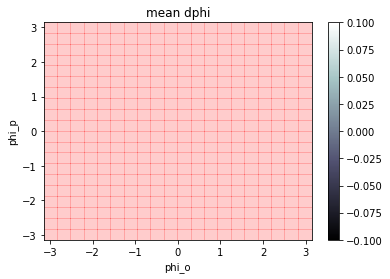

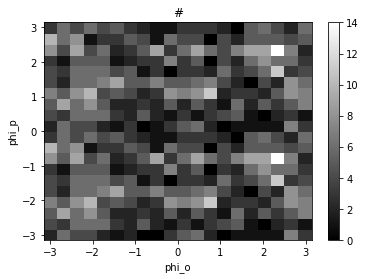

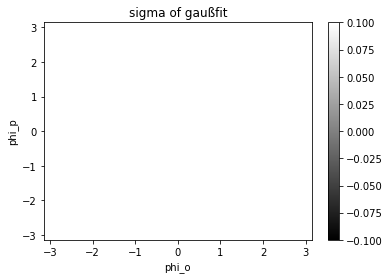

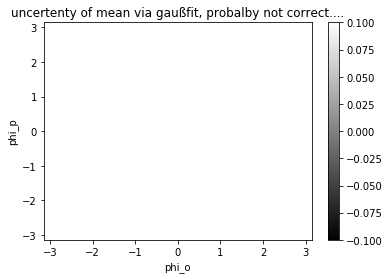

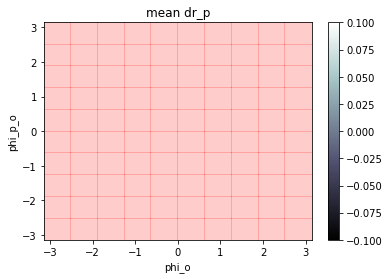

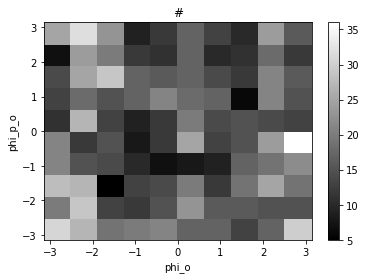

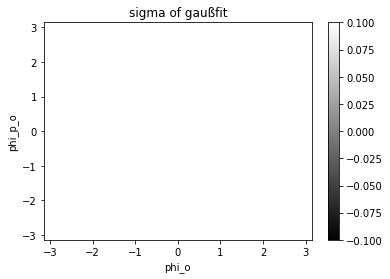

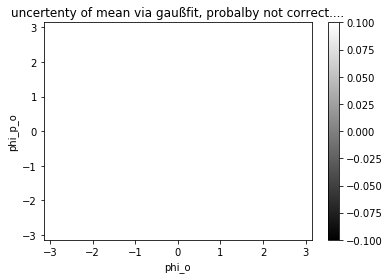

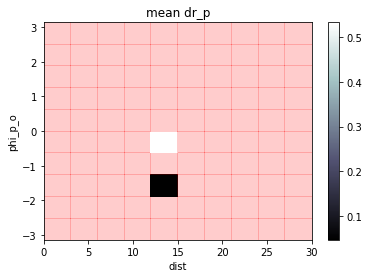

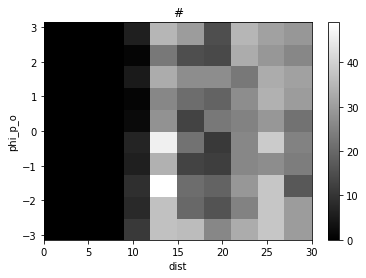

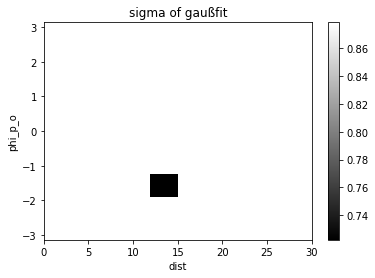

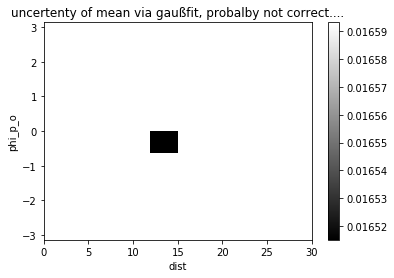

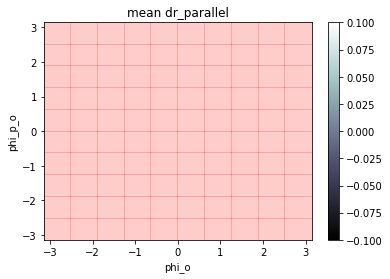

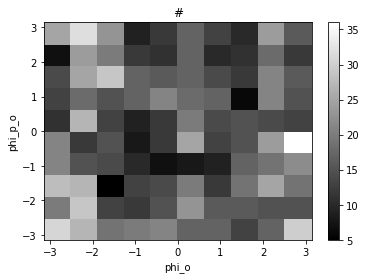

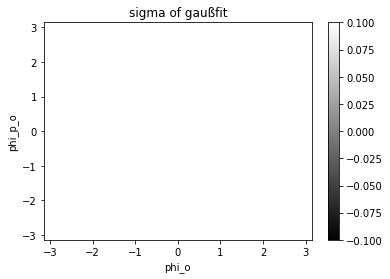

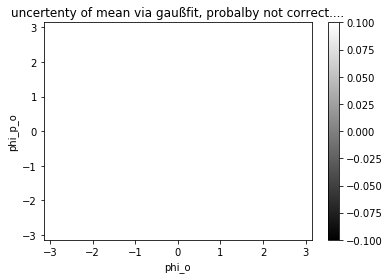

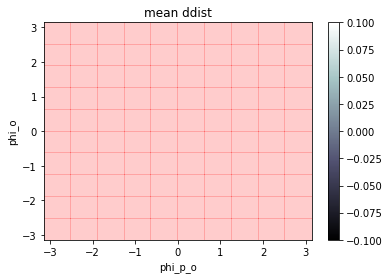

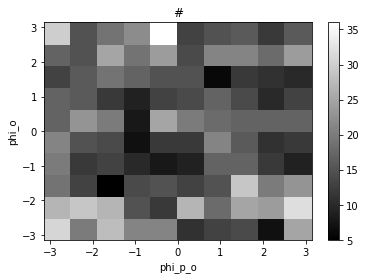

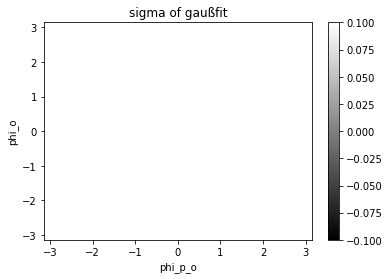

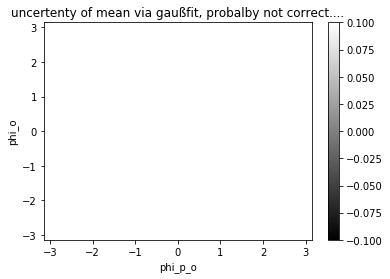

data has  dist  between  10.5  and  12


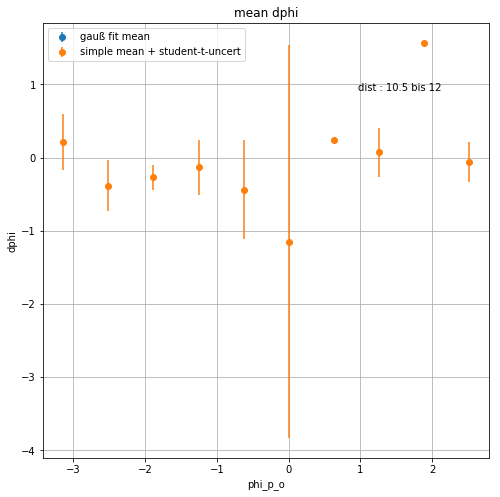

data has  dist  between  12  and  13.5


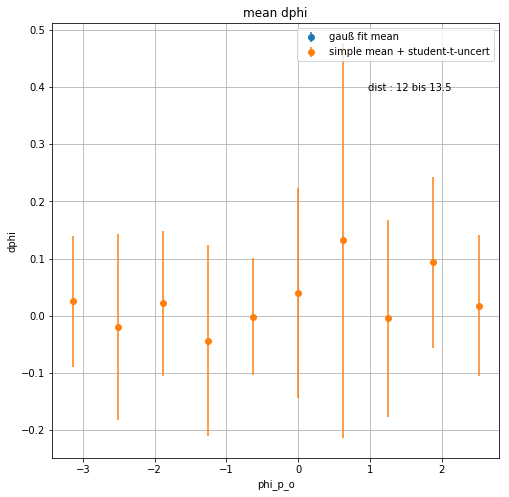

In [67]:
### do the whole fit orgi
Plot_position_desity()
Plot_phi_dist()
Plot_interparticle_distance_dist_weighted()
Plot_unfiltered_quantity_hist('dx',logy='on')
Plot_unfiltered_quantity_hist('dy',logy='on')
Plot_unfiltered_quantity_hist('dphi',logy='on')
Plot_unfiltered_quantity_hist('dphi_p_o',logy='on')
Plot_unfiltered_quantity_hist('dphi_o',logy='on')
Plot_unfiltered_quantity_hist('dphi_p',logy='on')
Plot_unfiltered_quantity_hist('dr_parallel',logy='on')
Plot_unfiltered_quantity_hist('dr_p',logy='on')
Plot_unfiltered_quantity_hist('ddist',logy='on')
Plot_mean_2bins_hist_dynamic(quantity = 'dphi',first = 'dist',second = 'phi_p_o',n_bin = 10)
Plot_mean_2bins_hist_dynamic(quantity = 'dphi',first = 'phi_p_o',second = 'phi_p',n_bin = 10)
Plot_mean_2bins_hist_dynamic(quantity = 'dphi',first = 'phi_o',second = 'phi_p_o',n_bin = 10)
Plot_mean_2bins_hist_dynamic(quantity = 'dphi',first = 'phi_o',second = 'phi_p',n_bin = 20)
Plot_mean_2bins_hist_dynamic(quantity = 'dr_p',first = 'phi_o',second = 'phi_p_o',n_bin = 10)
Plot_mean_2bins_hist_dynamic(quantity = 'dr_p',first = 'dist',second = 'phi_p_o',n_bin = 10)
Plot_mean_2bins_hist_dynamic(quantity = 'dr_parallel',first = 'phi_o',second = 'phi_p_o',n_bin = 10)
Plot_mean_2bins_hist_dynamic(quantity = 'ddist',first = 'phi_p_o',second = 'phi_o',n_bin = 10)


Plot_mean_bin_hist_dynamic_2(quantity = 'dphi',first = 'phi_p_o',second = 'dist',second_bin_index = 7,phi_bins=10,dist_bins = 20)
Plot_mean_bin_hist_dynamic_2(quantity = 'dphi',first = 'phi_p_o',second = 'dist',second_bin_index = 8,phi_bins=10,dist_bins = 20)







In [69]:
Plot_mean_2bins_hist_dynamic(quantity = 'dphi',first = 'ddist',second = 'phi_o',n_bin = 16)


KeyError: 'ddist'

In [269]:
plt.text?

In [70]:
## find particles with certain prperties
def Which_particles(first = 'dist_bin',i = 0,second = 'phi_po_bin',j = 0):
    first_bin = np.array(bin_dict[first])[i]
    second_bin = np.array(bin_dict[second])[j]
    t1.set_index([first,second,'particle'],drop = False,inplace = True)
    print('first bin is at: ',first_bin,'+binsize ; second is at: ', second_bin,' +binsize')
    print(t1.loc[first_bin,second_bin,:].index)

    return 
interact(Which_particles,first = 'dist_bin',i = (0,20),second = 'phi_po_bin',j = (0,20))

interactive(children=(Text(value='dist_bin', description='first'), IntSlider(value=0, description='i', max=20), Text(value='phi_po_bin', description='second'), IntSlider(value=0, description='j', max=20), Output()), _dom_classes=('widget-interact',))

<function __main__.Which_particles>

In [71]:
Plot_mean_bin_dist(quantity = 'dr',first = 'dist_bin',second = 'phi_po_bin')

NameError: name 'Plot_mean_bin_dist' is not defined

In [72]:
t1.head()

Unnamed: 0           x           y       phi  \
phi_p_o   dist                                                      
-2.768410 23.796313           0  377.195122  211.536585  2.326241   
-1.289584 23.796313           1  367.012658  233.044304 -2.294178   
-2.763631 23.833311           2  375.314286  212.182857  2.405017   
-0.776273 23.833311           3  366.949367  234.500000 -2.723933   
-2.602862 24.331091           4  373.825137  213.136612  2.345197   

                                                                  file  \
phi_p_o   dist                                                           
-2.768410 23.796313  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...   
-1.289584 23.796313  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...   
-2.763631 23.833311  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...   
-0.776273 23.833311  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...   
-2.602862 24.331091  /Users/Nic/Documents/tmp_Messdaten_storage/JP_...   

                     file_counter  frame_rel      x_rel     y_rel  \
phi_p_o   dist                                                      
-2.768410 23.796313             0          7   9.195122  9.536585   
-1.289584 23.796313             0          7  10.012658  9.044304   
-2.763631 23.833311             0          8   9.314286  9.182857   
-0.776273 23.833311             0          8   9.949367  9.500000   
-2.602862 24.331091             0          9   9.825137  9.136612   

                                     udlr     ...          phi_p  particle  \
phi_p_o   dist                                ...                            
-2.768410 23.796313  [220, 202, 368, 386]     ...      -0.442169         0   
-1.289584 23.796313  [242, 224, 357, 375]     ...       2.699424         1   
-2.763631 23.833311  [221, 203, 366, 384]     ...      -0.358613         0   
-0.776273 23.833311  [243, 225, 357, 375]     ...       2.782980         1   
-2.602862 24.331091  [222, 204, 364, 382]     ...      -0.257665         0   

                           dx        dy     ddist      dphi    dphi_o  \
phi_p_o   dist                                                          
-2.768410 23.796313       NaN       NaN       NaN       NaN       NaN   
-1.289584 23.796313       NaN       NaN       NaN       NaN       NaN   
-2.763631 23.833311 -1.880836  0.646272  0.036998  0.078777  0.508532   
-0.776273 23.833311 -0.063291  1.455696  0.036998 -0.429755  0.508532   
-2.602862 24.331091 -1.489149  0.953755  0.497779 -0.059821 -0.224696   

                       dphi_p  dphi_p_o  dphi_o_real  
phi_p_o   dist                                        
-2.768410 23.796313       NaN       NaN          NaN  
-1.289584 23.796313       NaN       NaN          NaN  
-2.763631 23.833311  0.083556  0.004779     0.508532  
-0.776273 23.833311  0.083556  0.513311    -0.508532  
-2.602862 24.331091  0.100948  0.160769    -0.224696  

[5 rows x 27 columns]

In [ ]:
plt.extend?

In [79]:
## interactive plot of image and trajectories
if 'tmp_file' in globals():
    del tmp_file
def Show_Trajectories(particle,i):
    frame = t1[t1.particle == particle].frame_rel.iat[i]
    y = t1[t1.particle == particle].y.iat[i]
    x = t1[t1.particle == particle].x.iat[i] #-"-   # something is messupo here but it works
    #plt.figure(figsize=(10,10))
    #print(type(Tracked_particles[Tracked_particles.particle == particle].file.iat[i]))
    file = t1[t1.particle == particle].file.iat[i]
    if 'tmp_file' not in globals():
        global tmp_file; tmp_file = file
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    if file != tmp_file:
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    plt.figure(dpi=300)
    ax = plt.gca()
    ax.cla() # clear things for fresh plot
    circle1 = plt.Circle((512//2, 512//2), 120, color='r', fill=False)
    ax.imshow(tmp_series[frame],cmap = 'gray')
    ax.scatter(x,y,s=10,marker = '+',c='red',lw = 0.5)
    ax.add_artist(circle1)
    ax.plot(t1[t1.particle == particle].x,t1[t1.particle == particle].y)
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/expample_marked_particle')
    plt.show()
    print('x,y = ',x,y, '  ; frame', frame, '  ; file ',file)
    global tmp_file; tmp_file = file
    return
interact(Show_Trajectories,particle = (0,50), i = (0,40))

SyntaxError: name 'tmp_series' is assigned to before global declaration (<ipython-input-79-8b22b1d347c3>, line 30)

In [7]:
t1.index

NameError: name 't1' is not defined

In [80]:
## anlgle correspondence
if 'tmp_file' in globals():
    del tmp_file
def Show_Trajectories(particle,i):
    frame = t1[t1.particle == particle].frame_rel.iat[i]
    y = t1[t1.particle == particle].y.iat[i]
    x = t1[t1.particle == particle].x.iat[i] #-"-   # something is messupo here but it works
    phi_po = t1[t1.particle == particle].phi_p_o.iat[i]
    phi_o = t1[t1.particle == particle].phi_o.iat[i]
    phi_p = t1[t1.particle == particle].phi_p.iat[i]
    phi = t1[t1.particle == particle].phi.iat[i]
    partnerstatus = t1[t1.particle == particle].master_index.iat[i]%2
    print('phi = ',phi,' ; phi_p_o = ',phi_po,';  phi_o = ',phi_o,';  phi_p = ',phi_p, '  ; partner_status ',partnerstatus)
    #plt.figure(figsize=(10,10))
    #print(type(Tracked_particles[Tracked_particles.particle == particle].file.iat[i]))
    file = t1[t1.particle == particle].file.iat[i]
    if 'tmp_file' not in globals():
        global tmp_file; tmp_file = file
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    if file != tmp_file:
        tdms_file = TdmsFile(file)
        p=tdms_file.object().properties   
        dimx=int(p['dimx'])  
        dimy=int(p['dimy'])
        frames=int(p['dimz'])
        images=tdms_file.channel_data('Image','Image')
        series = images.reshape(frames,dimx,dimy)
        global tmp_series; tmp_series = series
        print('reloaded')
    plt.figure(dpi=300)
    ax = plt.gca()
    ax.cla() # clear things for fresh plot
    circle1 = plt.Circle((512//2, 512//2), 120, color='r', fill=False)
    ax.imshow(tmp_series[frame],cmap = 'gray')
    ax.scatter(x,y,s=10,marker = '+',c='red',lw = 0.5)
    ax.add_artist(circle1)
    #ax.plot(t1[t1.particle == particle].x,t1[t1.particle == particle].y)
    plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/expample_marked_particle')
    plt.show()
    print('x,y = ',x,y, '  ; frame', frame, '  ; file ',file)
    global tmp_file; tmp_file = file
    return
interact(Show_Trajectories,particle = (0,50), i = (0,40))

SyntaxError: name 'tmp_series' is assigned to before global declaration (<ipython-input-80-e3d5d3f2b8c9>, line 36)

In [81]:
### check if dx is claced correctly  
def Show_Check_disp(p,f_rel):
    t1.set_index(['particle','frame'],drop = False,inplace = True)
    x1 = float(t1.loc[(p),['x']].iloc[f_rel])
    y1 = float(t1.loc[(p),['y']].iloc[f_rel]) #-"-   # something is messupo here but it works
    x2 = float(t1.loc[(p),['x']].iloc[f_rel+1])
    y2 = float(t1.loc[(p),['y']].iloc[f_rel+1])
    dx = float(t1.loc[(p),['dx']].iloc[f_rel+1])
    dy = float(t1.loc[(p),['dy']].iloc[f_rel+1])
    print('frame ',float(t1.loc[(p),['frame']].iloc[f_rel]),' and ',float(t1.loc[(p),['frame']].iloc[f_rel+1]))
    print('particle ',float(t1.loc[(p),['particle']].iloc[f_rel]),' and ',float(t1.loc[(p),['particle']].iloc[f_rel+1]))
    #plt.figure(figsize=(10,10))
    #print(type(Tracked_particles[Tracked_particles.particle == particle].file.iat[i]))
    plt.figure(dpi=100)
    ax = plt.gca()
    ax.cla() # clear things for fresh plot
    ax.scatter([x1,x2],[y1,y2],s=10,marker = '+',c='red',lw = 1)
    plt.title('check if the dx is claced correctly')
    ax.plot([x1,x1+dx],[y1,y1+dy])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    return
interact(Show_Check_disp,p = (0,50), f_rel = (0,40))


interactive(children=(IntSlider(value=25, description='p', max=50), IntSlider(value=20, description='f_rel', max=40), Output()), _dom_classes=('widget-interact',))

<function __main__.Show_Check_disp>

In [ ]:
t1.set_index(['particle','frame'],drop = False,inplace = True)
t1.loc[(2),['x']].iloc[0]

[ 0.50356037  0.07336325  0.62907875 ... -0.64384433  0.41613517
 -0.12504751]
Fitted mean =  0.01393286191629152
Fitted standard deviation =  1.008670223892906


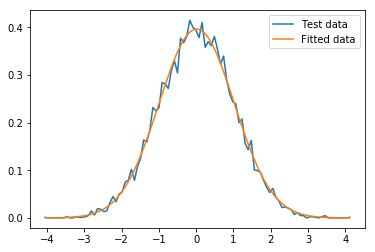

In [82]:
# from https://stackoverflow.com/questions/11507028/fit-a-gaussian-function/11507723#11507723
# thi is using fit routiens i guess


import numpy
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Define some test data which is close to Gaussian
data = numpy.random.normal(size=10000)
print(data)
hist, bin_edges = numpy.histogram(data, density=True,bins = 100)
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [1., 0., 1.]

coeff, var_matrix = curve_fit(gauss, bin_centres, hist, p0=p0)

# Get the fitted curve
hist_fit = gauss(bin_centres, *coeff)

plt.plot(bin_centres, hist, label='Test data')
plt.plot(bin_centres, hist_fit, label='Fitted data')
plt.legend()
# Finally, lets get the fitting parameters, i.e. the mean and standard deviation:
print('Fitted mean = ', coeff[1])
print('Fitted standard deviation = ', coeff[2])
plt.show()


mean1 =  29.91999238014358
(200,)
Fitted mean =  100.00000000000001
Fitted standard deviation =  3.1622776601683795


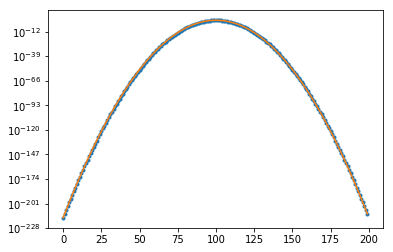

In [83]:
## from http://scipy-cookbook.readthedocs.io/items/FittingData.html
## just useing moments, and not fitting routiens, which is much faster
gaussian = lambda x: 3*np.exp(-(0-x)**2/20.)

data = gaussian(np.arange(-100,100))
#print(data)
print('mean1 = ',np.mean(np.random.normal(loc=30,scale=np.sqrt(20),size=100)))
print(data.shape)
plt.plot(data, '.')

X = np.arange(data.size)
x = np.sum(X*data)/np.sum(data)
width = np.sqrt(np.abs(np.sum((X-x)**2*data)/np.sum(data)))

max = data.max()

fit = lambda t : max*np.exp(-(t-x)**2/(2*width**2))

#plt.plot(fit(X), '-')
#plt.loglog(fit(X), '-')
plt.semilogy(fit(X), '-')
print('Fitted mean = ',x)
print('Fitted standard deviation = ', width)


In [248]:
plt.loglog?

In [55]:
Tracked_particles.to_csv('Tracked_particles.csv')   #save the data

In [56]:
t1.to_csv('t1.csv')

In [17]:
Tracked_particles = pd.read_csv('Tracked_particles.csv')

In [12]:
t1 = pd.read_csv('t1.csv')

FileNotFoundError: File b't1.csv' does not exist

In [16]:
t1.shape

(37974, 31)

In [ ]:
# test some data filtering with pandas

t1.set_index(['particle','frame'],drop = False,inplace = True)
t1_filtered = t1[(t1.frame > 5000) & (t1.frame < 6000)]
print(list(t1_filtered.dist_bin))

In [ ]:
plt.figure()
t1.set_index(['master_index'],drop = False,inplace = True);
t1_filtered = t1[(t1['distance_ij'] > 10) & (t1['distance_ij'] < 14)];
t1_filtered.groupby(['frame'])
counts, xedges,yedges,im = plt.hist2d(t1_filtered['phi'],t1_filtered['distance_ij'],bins = 30,range=[[-np.pi,np.pi],[10,14]])

plt.show()

In [ ]:
t6 = pd.read_csv('t1.csv')

In [ ]:
plt.hist2d?

/Users/Nic/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: 'master_index' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """
/Users/Nic/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


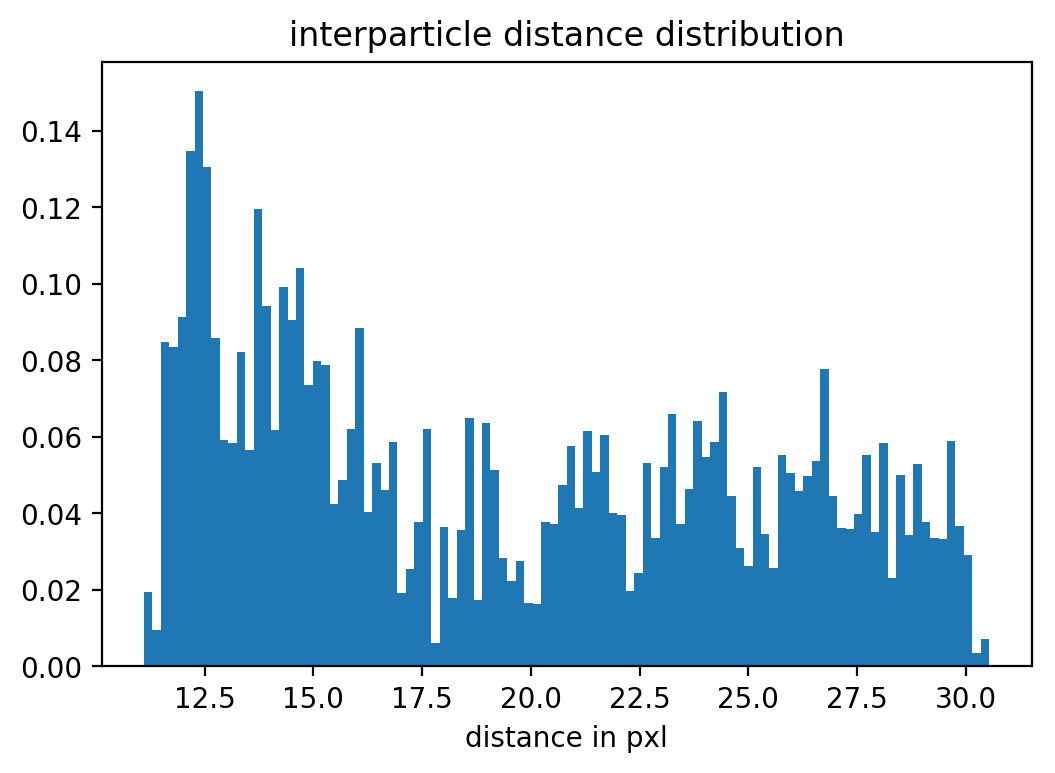

In [84]:
def Plot_interparticle_distance_dist_weighted():
    Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
    distance_list = []
    weight_list = []
    Tracked_particles.groupby('master_index')
    for i in range(0,len(Tracked_particles['x']),2):
        y1 = Tracked_particles['y'].loc[i]
        x1 = Tracked_particles['x'].loc[i]
        y2 = Tracked_particles['y'].loc[i+1]
        x2 = Tracked_particles['x'].loc[i+1]
        distance_ij = np.sqrt((x1-x2)**2+(y1-y2)**2)
        distance_list.append(distance_ij)
        weight_list.append(event_radius/distance_ij)
    plt.figure(dpi=200)
    plt.title('interparticle distance distribution')
    plt.xlabel('distance in pxl')
    plt.hist(distance_list,bins = 100,normed=True,weights=weight_list)
    #plt.savefig('C:/Users/Nicola/Desktop/tmp/Box_Analyse/distance_dist')
    plt.show()
    return
Plot_interparticle_distance_dist_weighted()

In [85]:
Tracked_particles.set_index(['master_index'],drop = False,inplace = True)
t1.set_index(['master_index'],drop = False,inplace = True)
print(len(t1.master_index))
print(len(Tracked_particles.master_index))


1806
1826


(32, 32)


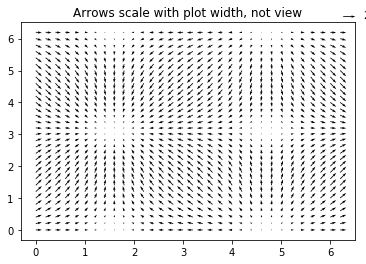

In [86]:
## for the phi xy plot

X, Y = np.meshgrid(np.arange(0, 2 * np.pi, .2), np.arange(0, 2 * np.pi, .2))
U = np.cos(X)
V = np.sin(Y)
print(U.shape)
plt.figure()
plt.title('Arrows scale with plot width, not view')
Q = plt.quiver(X, Y, U, V, units='width')
qk = plt.quiverkey(Q, 0.9, 0.9, 2, r'$2 \frac{m}{s}$', labelpos='E',
                   coordinates='figure')

N 1802


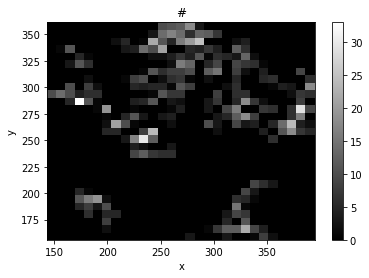

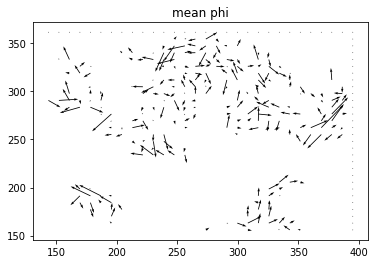

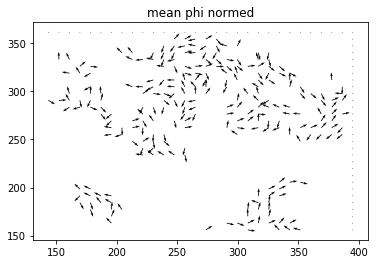

N 1802
number of phis used / magitude of added up orient. vectors =  32.792025390327716


In [87]:
### phi XY plot

def Plot_Phi_XY():
    bins = 30
    x_list = np.linspace(np.min(t1.x),np.max(t1.x),bins)
    y_list = np.linspace(np.min(t1.y),np.max(t1.y),bins)
    N_hist = np.zeros((bins,bins))
    phi_hist = np.zeros((bins,bins))
    o1_list = np.zeros((bins,bins))
    o2_list = np.zeros((bins,bins))
    o1_list_normed = np.zeros((bins,bins))
    o2_list_normed = np.zeros((bins,bins))
    N = 0
    for i in range(bins-1):
        for j in range(bins-1):
            t1.set_index(['master_index'],drop = False,inplace = True)
            t1_filtered = t1[(t1['x'] > x_list[i]) & (t1['x'] < x_list[i+1])
                             & (t1['y'] > y_list[j]) & (t1['y'] < y_list[j+1])
                             & (np.isfinite(np.array(t1['x'])))
                             ]
            N_hist[i,j] = len(np.array(t1_filtered.x))
            o1 = 0
            o2 = 0
            for k in range(len(np.array(t1_filtered.x))):
                o1 += np.cos(np.array(t1_filtered['phi'])[k])
                o2 += np.sin(np.array(t1_filtered['phi'])[k])
                N += 1
            phi = np.arctan2(o2,o1)
            phi_hist[i,j] = phi
            o1_list[i,j] = o1
            o2_list[i,j] = o2
            o1_list_normed[i,j] = np.cos(phi)
            o2_list_normed[i,j] = np.sin(phi)
            if len(np.array(t1_filtered.x)) ==0:
                phi_hist[i,j] = np.nan
                o1_list[i,j] = np.nan
                o2_list[i,j] = np.nan
                o1_list_normed[i,j] = np.nan
                o2_list_normed[i,j] = np.nan
    print('N',N)
    plt.figure()
    plt.pcolormesh(x_list, y_list, N_hist,cmap = 'gray')
    #plt.imshow(M_N,cmap = 'gray')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('#')
    plt.colorbar()
    #plt.savefig()
    plt.show()
    
    plt.figure()
    plt.title('mean phi')
    Q = plt.quiver(x_list, y_list,o1_list,o2_list, units='width')
    plt.savefig('phi_XY')
    plt.show()
    
    plt.figure()
    plt.title('mean phi normed')
    Q = plt.quiver(x_list, y_list,o1_list_normed,o2_list_normed, units='width')
    plt.savefig('phi_XY_normed')
    plt.show()
    
    bins = 2
    x_list = np.linspace(np.min(t1.x),np.max(t1.x),bins)
    y_list = np.linspace(np.min(t1.y),np.max(t1.y),bins)
    N_hist = np.zeros((bins,bins))
    phi_hist = np.zeros((bins,bins))
    o1_list = np.zeros((bins,bins))
    o2_list = np.zeros((bins,bins))
    o1_list_normed = np.zeros((bins,bins))
    o2_list_normed = np.zeros((bins,bins))
    N = 0
    for i in range(bins-1):
        for j in range(bins-1):
            t1.set_index(['master_index'],drop = False,inplace = True)
            t1_filtered = t1[(t1['x'] > x_list[i]) & (t1['x'] < x_list[i+1])
                             & (t1['y'] > y_list[j]) & (t1['y'] < y_list[j+1])
                             & (np.isfinite(np.array(t1['x'])))
                             ]
            N_hist[i,j] = len(np.array(t1_filtered.x))
            o1 = 0
            o2 = 0
            for k in range(len(np.array(t1_filtered.x))):
                o1 += np.cos(np.array(t1_filtered['phi'])[k])
                o2 += np.sin(np.array(t1_filtered['phi'])[k])
                N += 1
            phi = np.arctan2(o2,o1)
            phi_hist[i,j] = phi
            o1_list[i,j] = o1
            o2_list[i,j] = o2
    print('N',N)
    print('number of phis used / magitude of added up orient. vectors = ',N/np.sqrt(o1_list[0,0]**2+o2_list[0,0]**2))
    return
Plot_Phi_XY()